In [1]:
import sys
sys.path.insert(0, "../")
from SC_Utils.game_utils import ObsProcesser, get_action_dict
#from SC_Utils.train_MaxEnt import *
from SC_Utils.train_v3 import *
from SC_Utils.inspection_plots import *
import AC_modules.Networks as net
from AC_modules.BatchedA2C import SpatialA2C, SpatialA2C_v1, SpatialA2C_v2, SpatialA2C_v3
from AC_modules.BatchedA2C import SpatialA2C_MaxEnt, SpatialA2C_MaxEnt_v2
import torch
import numpy as np
import matplotlib.pyplot as plt

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


# Online plotting of the training

In [2]:
filename = '../Results/FindAndDefeatZerglings/Logging/PRGY.txt'
#filename = '../Results/MoveToBeacon/Logging/EOEV.txt'
logging = np.loadtxt(filename, delimiter=',', skiprows=1)

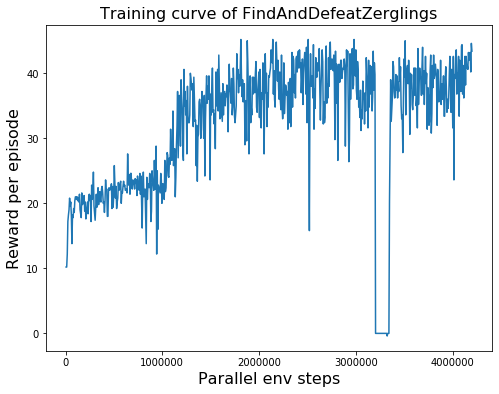

In [3]:
plt.figure(figsize=(8,6))
plt.plot(logging[:,0], logging[:,1])
plt.xlabel("Parallel env steps", fontsize=16)
plt.ylabel("Reward per episode", fontsize=16)
plt.title("Training curve of FindAndDefeatZerglings", fontsize=16)
plt.show()

In [83]:
jump = 60000
n = 70
step_idx =jump*n
step_idx

4200000

# Trajectories

In [84]:
game_names = {1:'MoveToBeacon',
              2:'CollectMineralShards',
              3:'DefeatRoaches',
              4:'FindAndDefeatZerglings',
              5:'DefeatZerglingsAndBanelings',
              6:'CollectMineralsAndGas',
              7:'BuildMarines'
              }
map_name = game_names[4]

In [85]:
load_dir = "../Results/"+map_name+"/Inspection/"
PID = "PRGY"
step_idx = step_idx
insp_dict = np.load(load_dir+PID+"_"+str(step_idx)+".npy", allow_pickle=True).item()

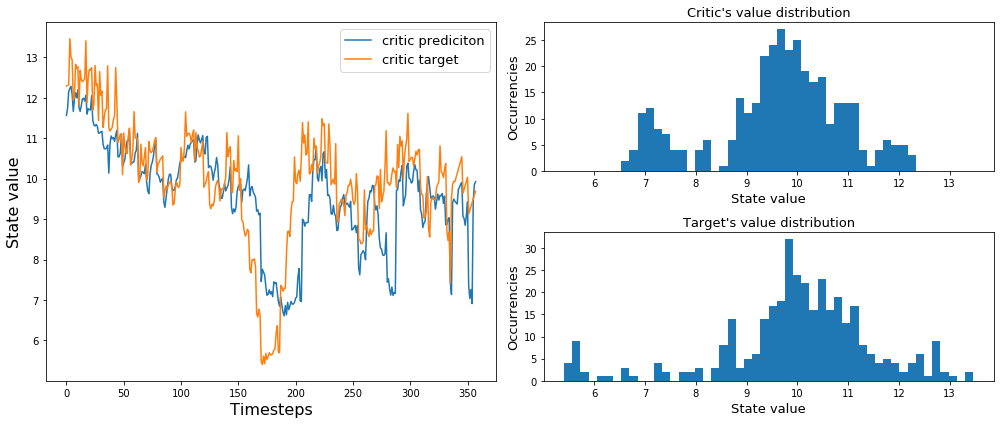

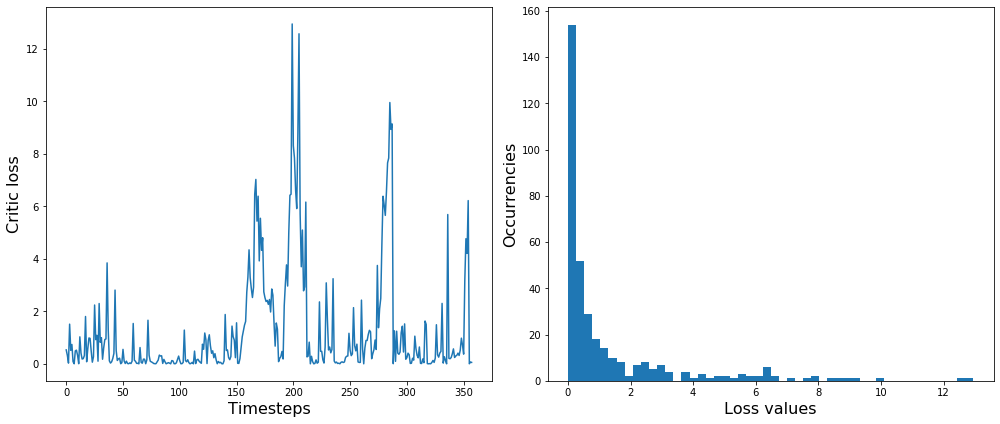

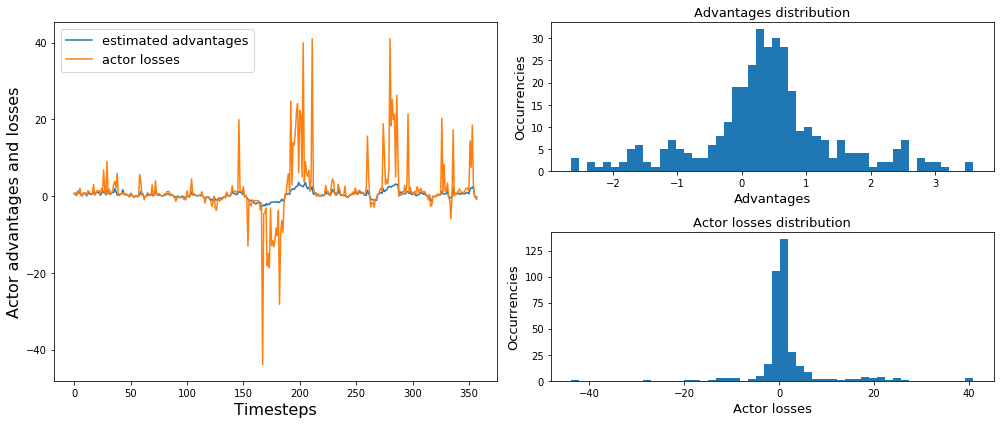

In [86]:
plot_update_curves(insp_dict)

# Agent related visualization

In [87]:
# Environment parameters
RESOLUTION = 32
MAX_STEPS = 256
game_params = dict(feature_screen=RESOLUTION, feature_minimap=RESOLUTION, action_space="FEATURES") 
game_names = {1:'MoveToBeacon',
              2:'CollectMineralShards',
              3:'DefeatRoaches',
              4:'FindAndDefeatZerglings',
              5:'DefeatZerglingsAndBanelings',
              6:'CollectMineralsAndGas',
              7:'BuildMarines'
              }
map_name = game_names[4]

# Observation Processer parameters
#screen_names = ['visibility_map', 'player_relative', 'selected', 'unit_density', 'unit_density_aa']
#minimap_names = []
#obs_proc_params = {'screen_names':screen_names, 'minimap_names':minimap_names}
obs_proc_params = {'select_all':True}
env = init_game(game_params, map_name)
op = ObsProcesser(**obs_proc_params)
screen_channels, minimap_channels = op.get_n_channels()
in_channels = screen_channels + minimap_channels 
#action_names = ['select_army', 'Attack_screen', 'Move_screen']
#action_names = ['no_op', 'select_army', 'Attack_screen', 'Move_screen', 'select_point', 'select_rect']
action_names = ['select_army', 'Attack_screen', 'Move_screen', 'select_point', 'select_rect',
                'move_camera','Stop_quick','Move_minimap','Attack_minimap','HoldPosition_quick']
action_dict = get_action_dict(action_names)

In [88]:
PID = 'PRGY'#'TYUY'#'SFFA'#'HHRC'
load=False
if load:
    agent = torch.load("../Results/"+map_name+"/agent_"+PID, map_location='cpu')
    agent.device = 'cpu'
else:
    action_space = len(action_dict)
    spatial_model = net.FullyConvSpatial
    nonspatial_model = net.FullyConvNonSpatial
    embed_dim = 8
    n_channels = 32
    n_features = 256
    spatial_dict = {"in_channels":in_channels}
    nonspatial_dict = {'resolution':RESOLUTION, 'kernel_size':3, 'stride':2}
    HPs = dict(action_space=action_space, n_steps=20, H=1e-3, 
           spatial_model=spatial_model, nonspatial_model=nonspatial_model,
           n_features=n_features, n_channels=n_channels, 
           spatial_dict=spatial_dict, nonspatial_dict=nonspatial_dict, 
           action_dict=action_dict)

    HPs['device'] = 'cpu'
    version = 2
    if version == 1:
        HPs = {**HPs, 'embed_dim':embed_dim}
        agent = SpatialA2C_v1(env=env, **HPs)
    elif version == 2:
        # no action embedding
        agent = SpatialA2C_v2(env=env, **HPs)
    elif version == 3:
        agent = SpatialA2C_v3(env=env, **HPs)
    elif version == 4:
        agent = SpatialA2C_MaxEnt(env=env, **HPs)
    elif version == 5:
        agent = SpatialA2C_MaxEnt_v2(env=env, **HPs)
    else:
        raise Exception("Version not implemented.")
        
    # Load proper checkpoint here
    agent.AC.load_state_dict(torch.load("../Results/"+map_name+"/Checkpoints/"+PID+"_"+str(step_idx), map_location='cpu'))

In [89]:
inspector = inspection_test(step_idx, agent, env, PID, op, action_dict)

In [90]:
_, layer_names = op.get_state(env.reset())
layer_names

{'screen_names': array(['visibility_map_1', 'visibility_map_2', 'player_id_1',
        'player_id_2', 'player_id_16', 'player_relative_1',
        'player_relative_3', 'player_relative_4', 'unit_type_9',
        'unit_type_18', 'unit_type_48', 'unit_type_105', 'unit_type_110',
        'unit_type_317', 'unit_type_341', 'unit_type_342',
        'unit_type_1680', 'selected_1', 'unit_hit_points',
        'unit_hit_points_ratio', 'unit_density', 'unit_density_aa',
        'pathable_1', 'buildable_1'], dtype='<U21'),
 'minimap_names': array(['visibility_map_1', 'visibility_map_2', 'camera_1', 'player_id_1',
        'player_id_2', 'player_id_16', 'player_relative_1',
        'player_relative_3', 'player_relative_4', 'selected_1',
        'pathable_1', 'buildable_1'], dtype='<U17')}

In [91]:
remove = True
if remove:
    remove_names = ['unit_type_20','unit_type_45'] # added after the inspection was done
    layer_names['screen_names'] = np.array([name for name in layer_names['screen_names'] if name not in remove_names])
layer_names['screen_names']

array(['visibility_map_1', 'visibility_map_2', 'player_id_1',
       'player_id_2', 'player_id_16', 'player_relative_1',
       'player_relative_3', 'player_relative_4', 'unit_type_9',
       'unit_type_18', 'unit_type_48', 'unit_type_105', 'unit_type_110',
       'unit_type_317', 'unit_type_341', 'unit_type_342',
       'unit_type_1680', 'selected_1', 'unit_hit_points',
       'unit_hit_points_ratio', 'unit_density', 'unit_density_aa',
       'pathable_1', 'buildable_1'], dtype='<U21')

In [92]:
insp_dict = inspector.dict


Step 0
Action select_army - prob: 0.059
Action Attack_screen - prob: 0.744
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.007
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.119
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.071
-----------------------------------
Action chosen:  Attack_screen


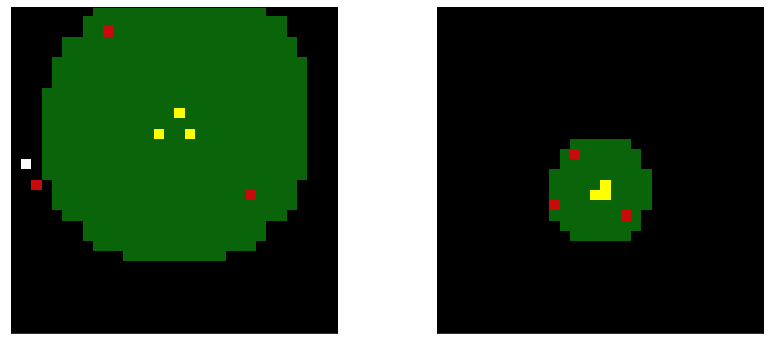

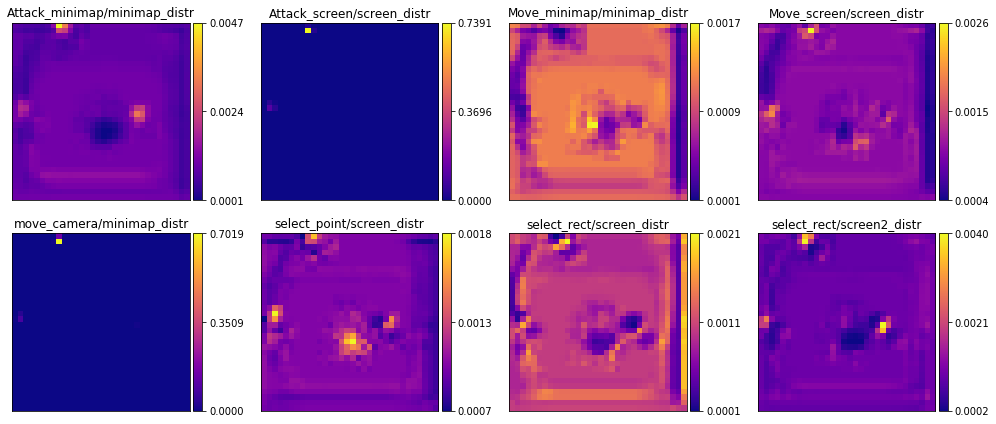


Step 1
Action select_army - prob: 0.125
Action Attack_screen - prob: 0.616
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.009
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.176
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.074
-----------------------------------
Action chosen:  Attack_screen


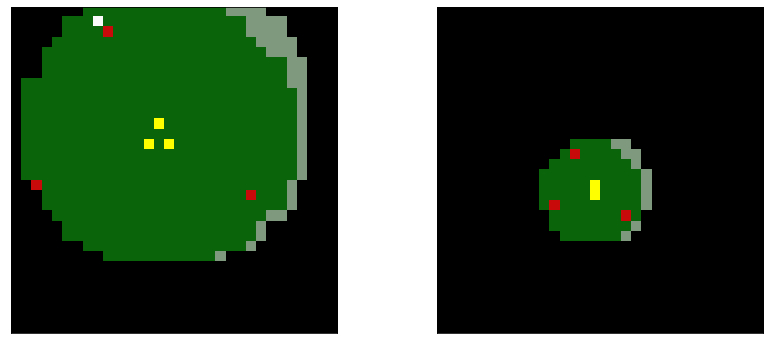

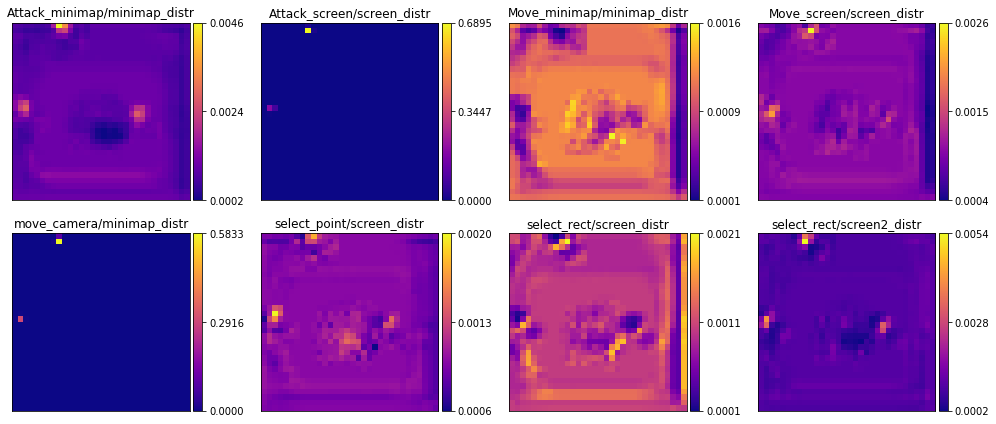


Step 2
Action select_army - prob: 0.174
Action Attack_screen - prob: 0.544
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.010
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.193
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.079
-----------------------------------
Action chosen:  Attack_screen


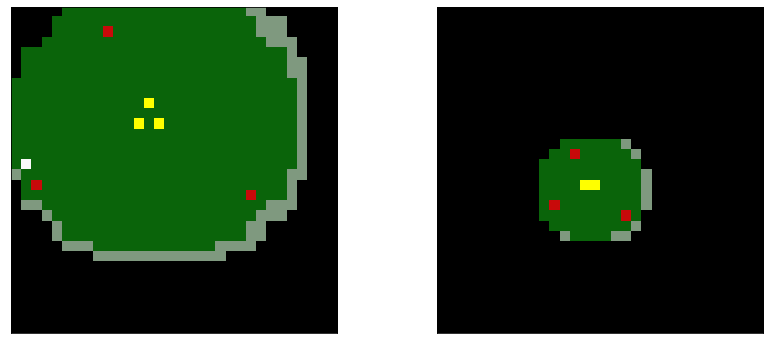

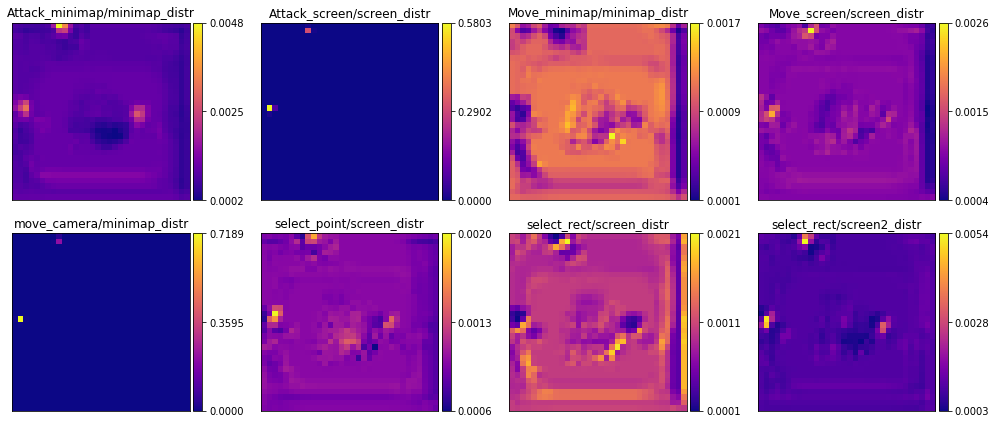


Step 3
Action select_army - prob: 0.352
Action Attack_screen - prob: 0.285
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.012
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.226
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.126
-----------------------------------
Action chosen:  select_army


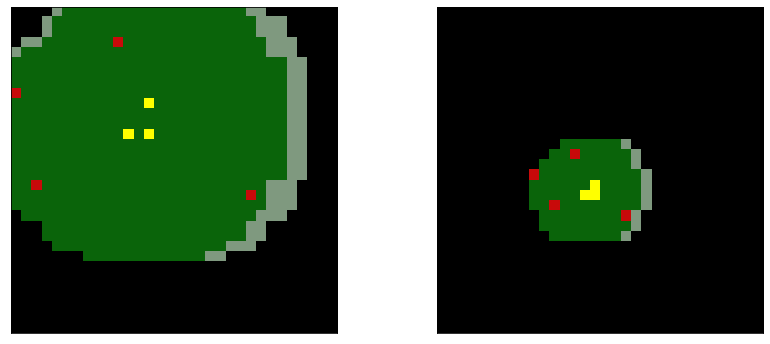

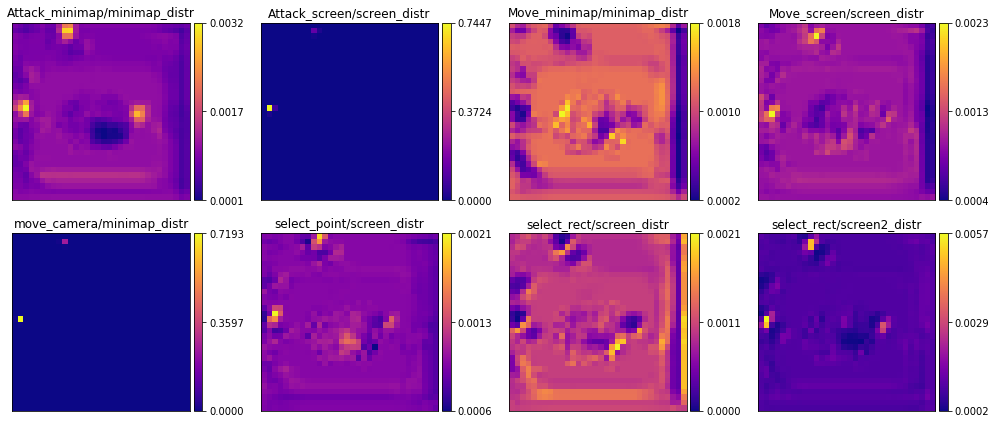


Step 4
Action select_army - prob: 0.470
Action Attack_screen - prob: 0.235
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.010
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.188
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.098
-----------------------------------
Action chosen:  select_army


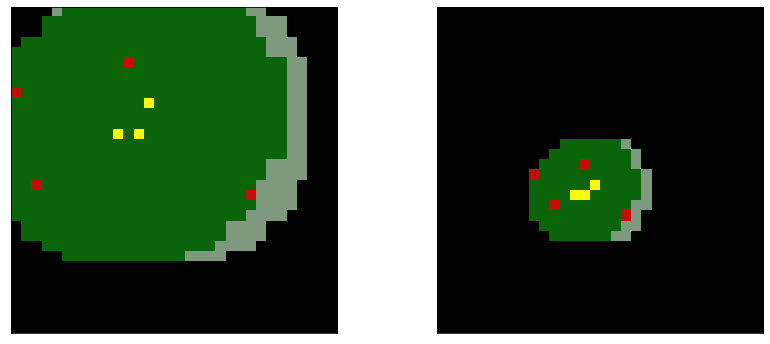

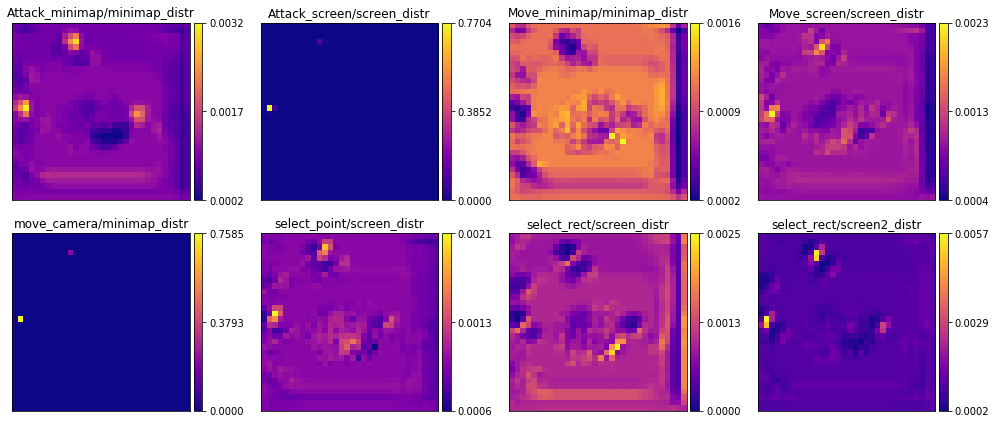


Step 5
Action select_army - prob: 0.461
Action Attack_screen - prob: 0.249
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.010
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.189
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.091
-----------------------------------
Action chosen:  Attack_screen


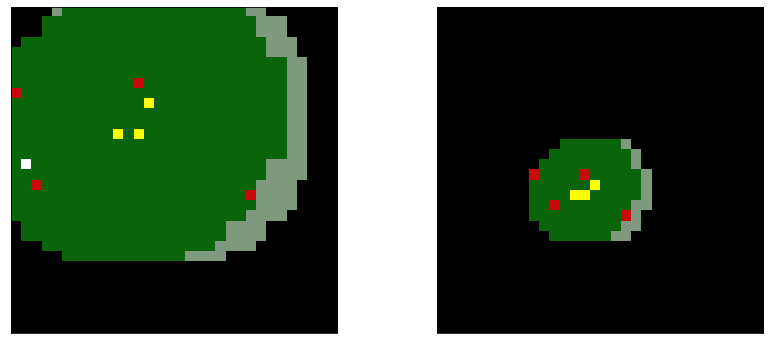

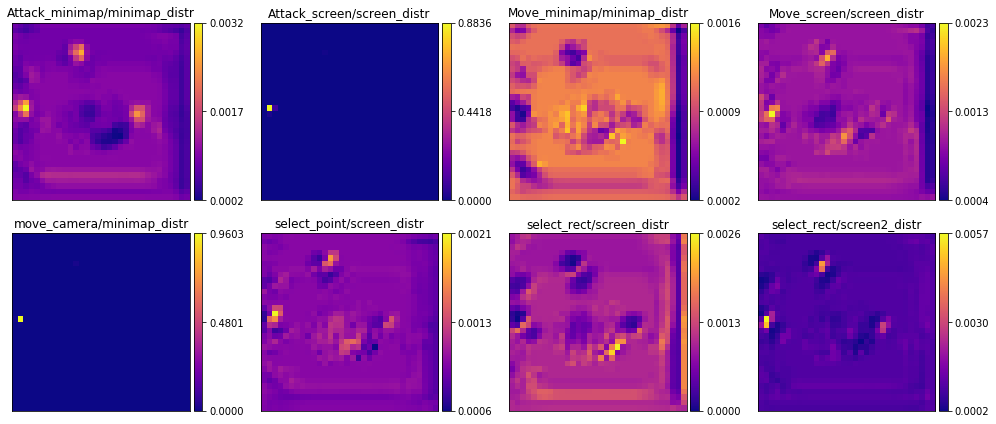


Step 6
Action select_army - prob: 0.151
Action Attack_screen - prob: 0.586
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.008
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.187
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.067
-----------------------------------
Action chosen:  Attack_screen


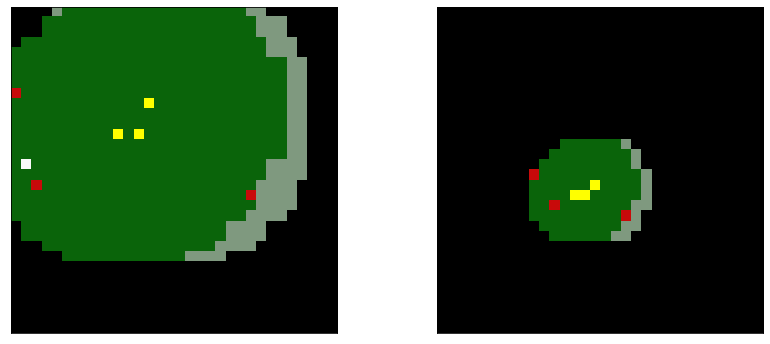

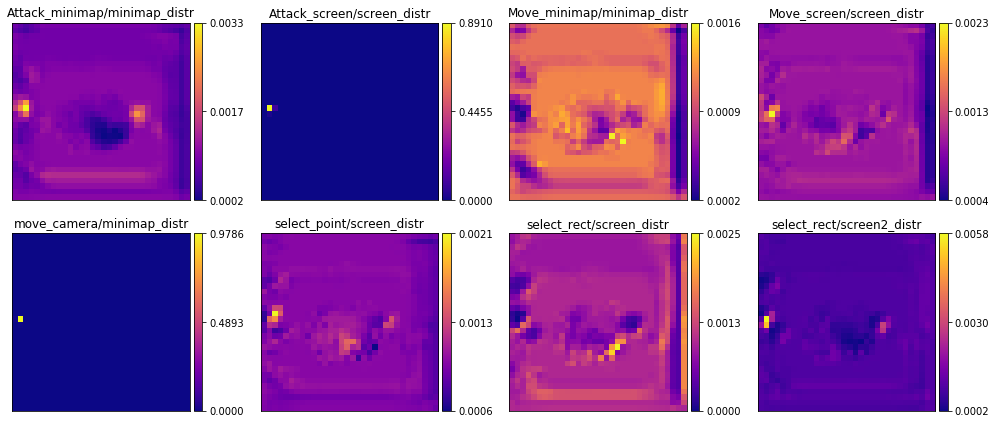


Step 7
Action select_army - prob: 0.110
Action Attack_screen - prob: 0.651
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.009
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.168
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.062
-----------------------------------
Action chosen:  Attack_screen


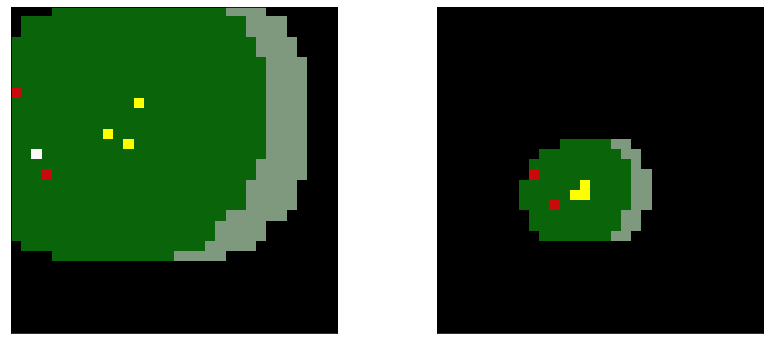

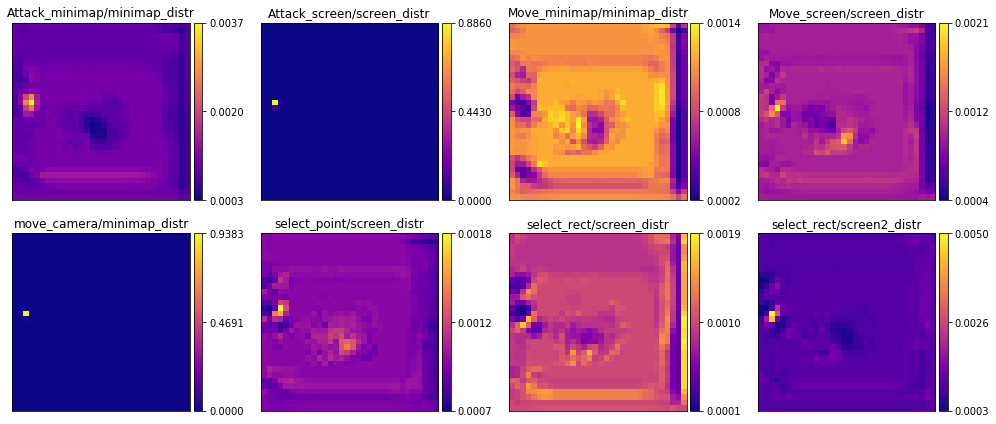


Step 8
Action select_army - prob: 0.137
Action Attack_screen - prob: 0.555
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.014
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.203
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.091
-----------------------------------
Action chosen:  Attack_screen


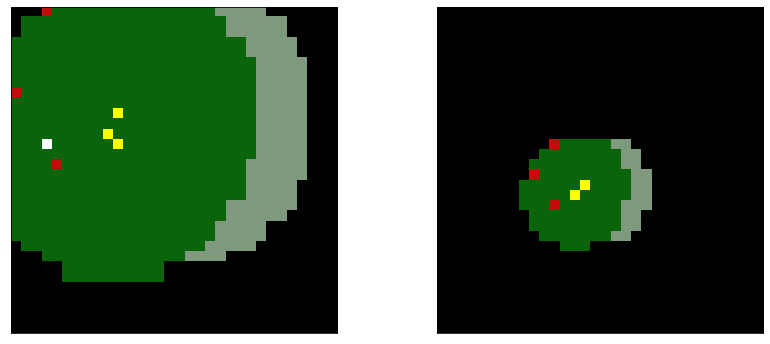

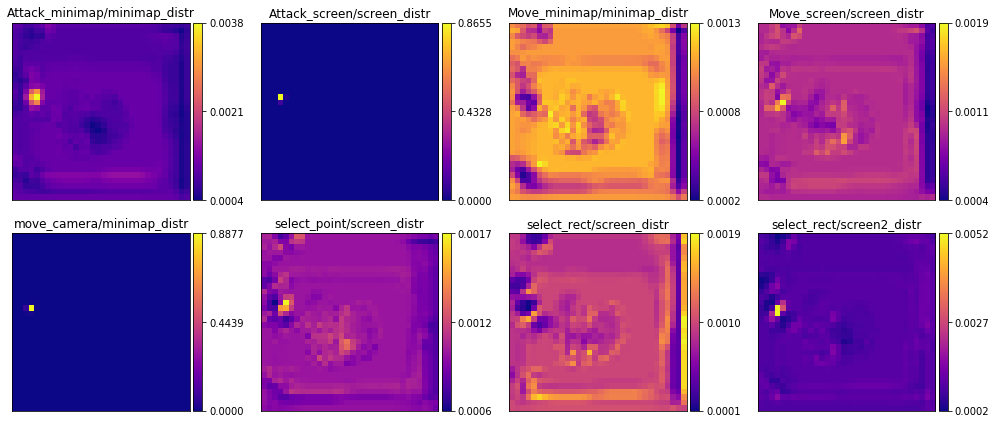


Step 9
Action select_army - prob: 0.208
Action Attack_screen - prob: 0.410
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.021
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.212
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.149
-----------------------------------
Action chosen:  select_army


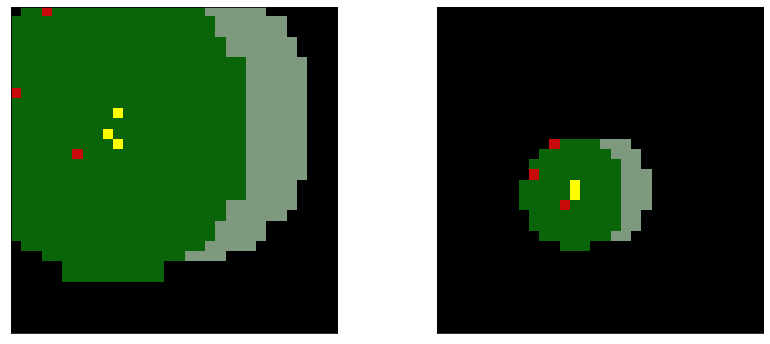

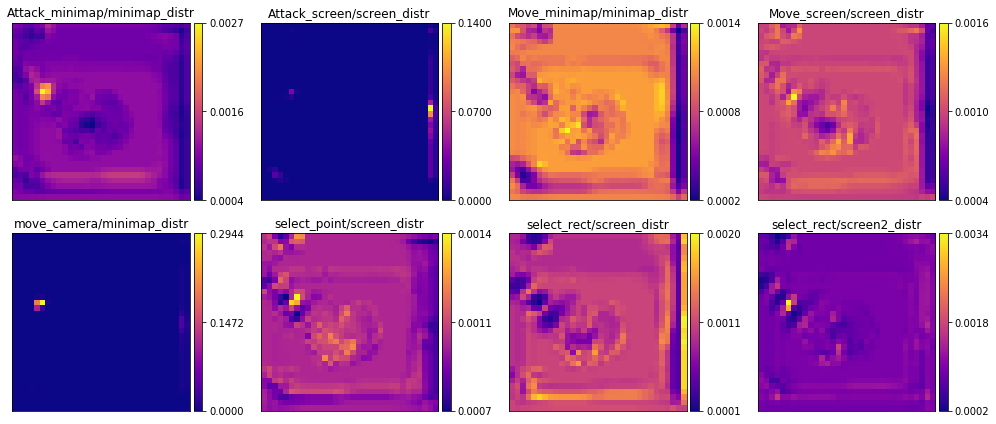


Step 10
Action select_army - prob: 0.060
Action Attack_screen - prob: 0.668
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.010
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.187
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.073
-----------------------------------
Action chosen:  Attack_screen


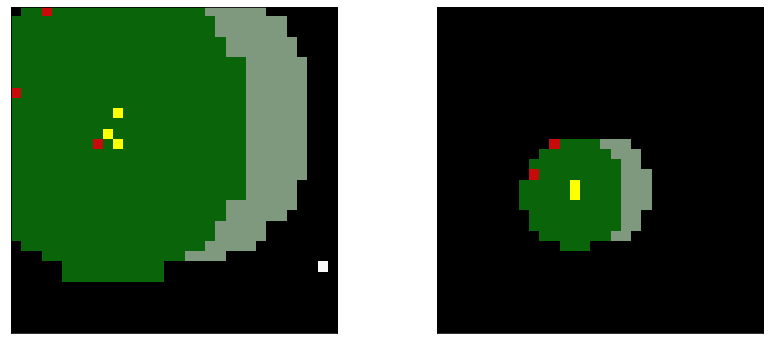

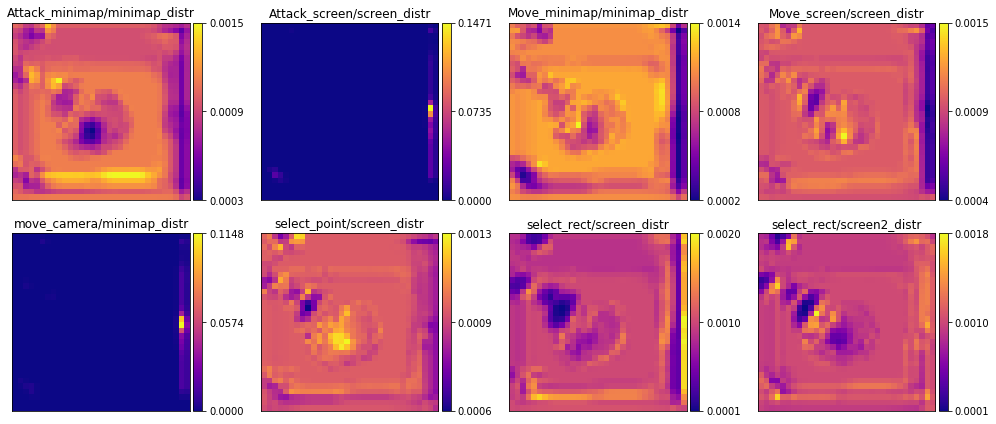


Step 11
Action select_army - prob: 0.037
Action Attack_screen - prob: 0.774
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.007
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.136
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.046
-----------------------------------
Action chosen:  Attack_screen


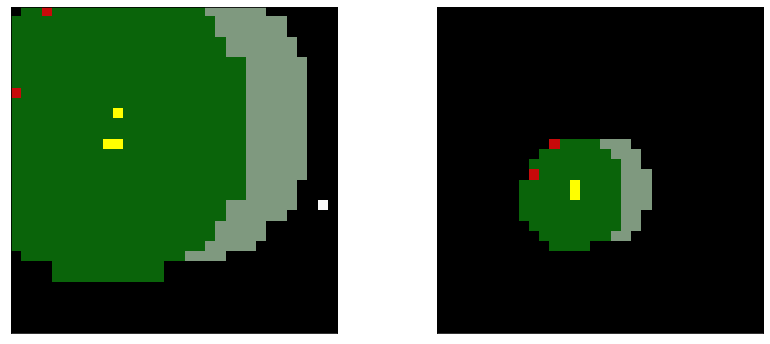

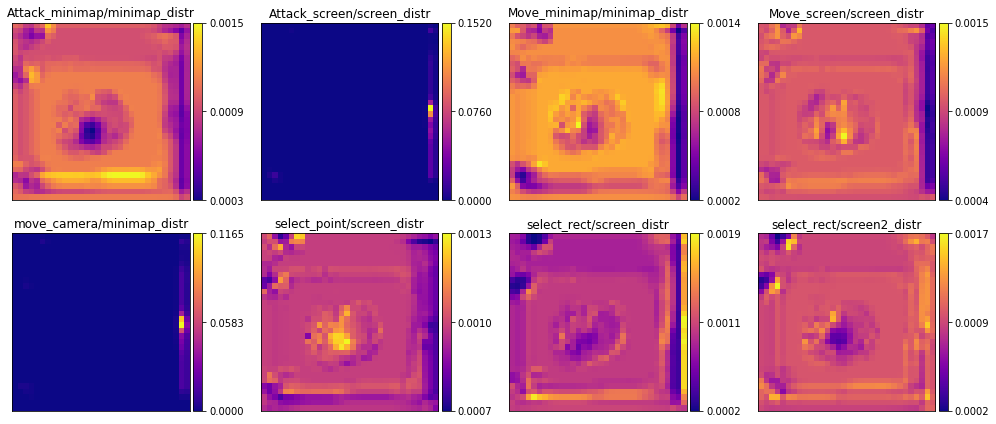


Step 12
Action select_army - prob: 0.019
Action Attack_screen - prob: 0.863
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.002
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.086
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.029
-----------------------------------
Action chosen:  Attack_screen


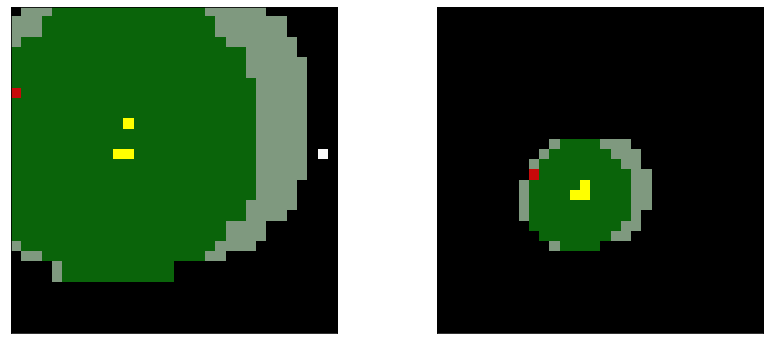

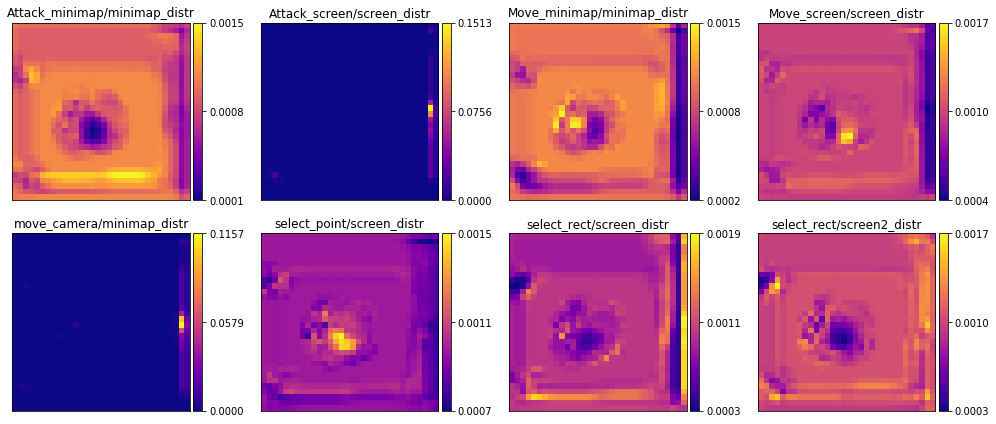


Step 13
Action select_army - prob: 0.094
Action Attack_screen - prob: 0.690
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.009
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.158
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.049
-----------------------------------
Action chosen:  Attack_screen


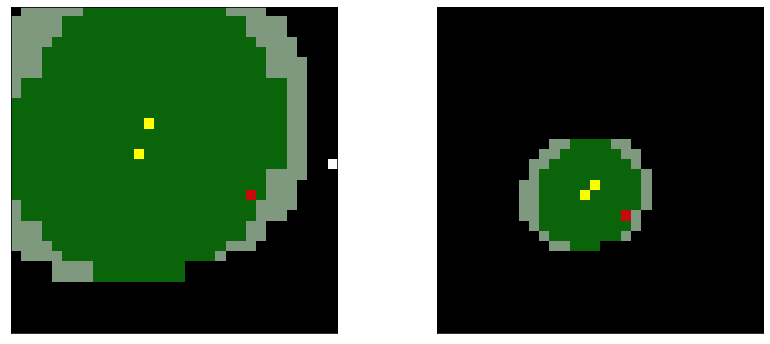

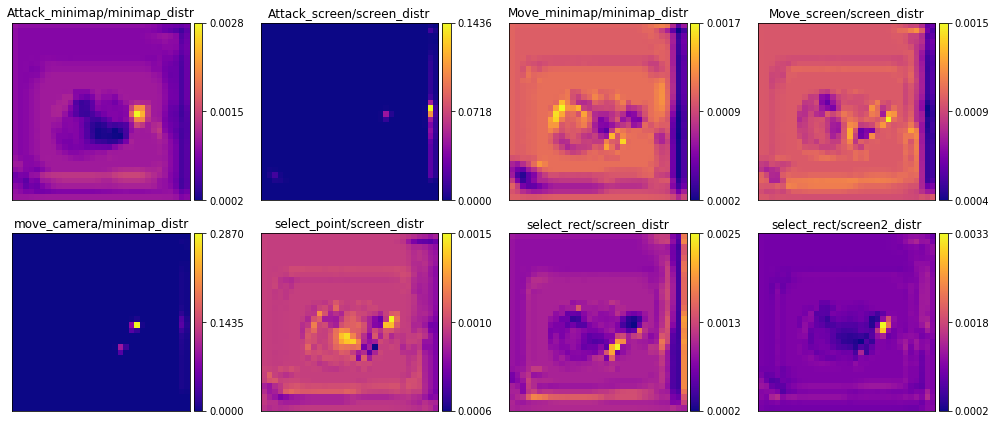


Step 14
Action select_army - prob: 0.182
Action Attack_screen - prob: 0.510
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.018
Action move_camera - prob: 0.001
Action Stop_quick - prob: 0.211
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.077
-----------------------------------
Action chosen:  Attack_screen


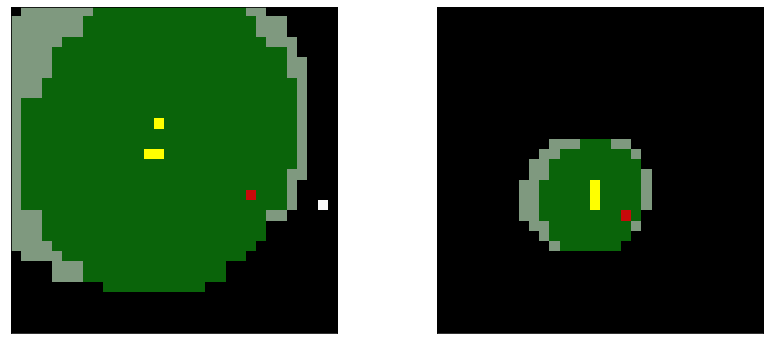

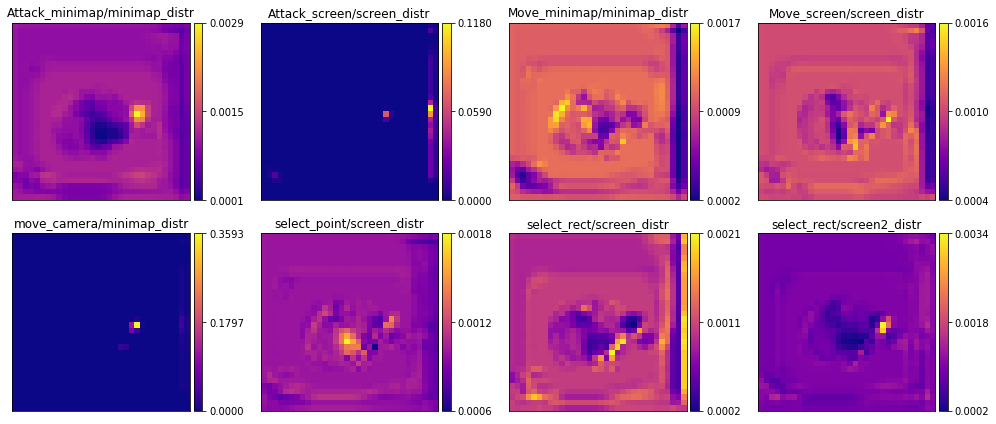


Step 15
Action select_army - prob: 0.293
Action Attack_screen - prob: 0.371
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.019
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.233
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.086
-----------------------------------
Action chosen:  select_army


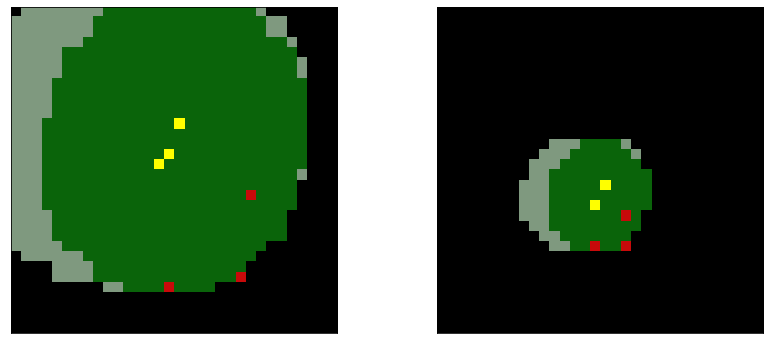

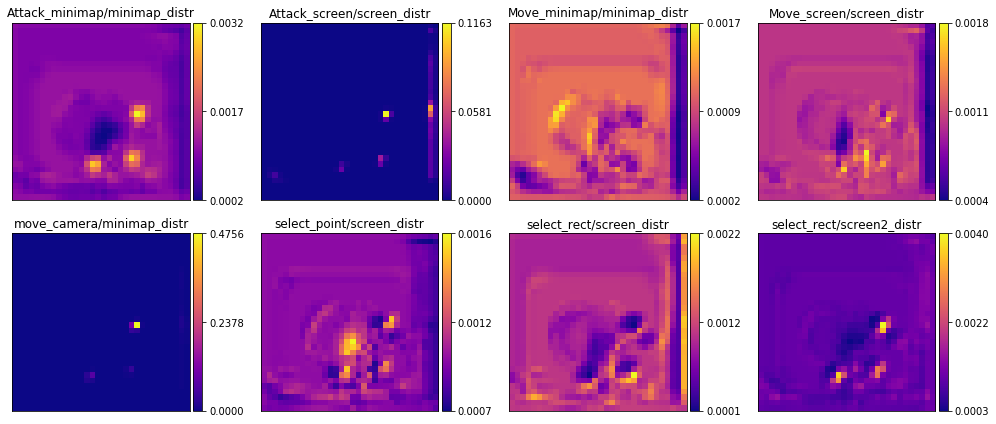


Step 16
Action select_army - prob: 0.186
Action Attack_screen - prob: 0.424
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.033
Action move_camera - prob: 0.032
Action Stop_quick - prob: 0.218
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.106
-----------------------------------
Action chosen:  HoldPosition_quick


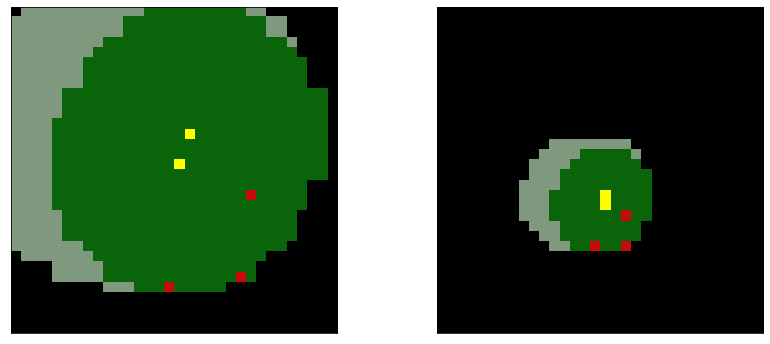

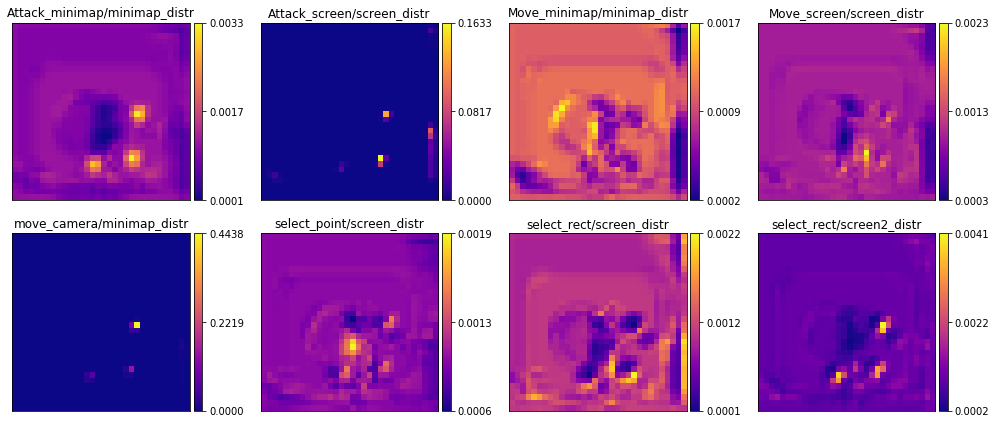


Step 17
Action select_army - prob: 0.189
Action Attack_screen - prob: 0.435
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.031
Action move_camera - prob: 0.025
Action Stop_quick - prob: 0.215
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.105
-----------------------------------
Action chosen:  HoldPosition_quick


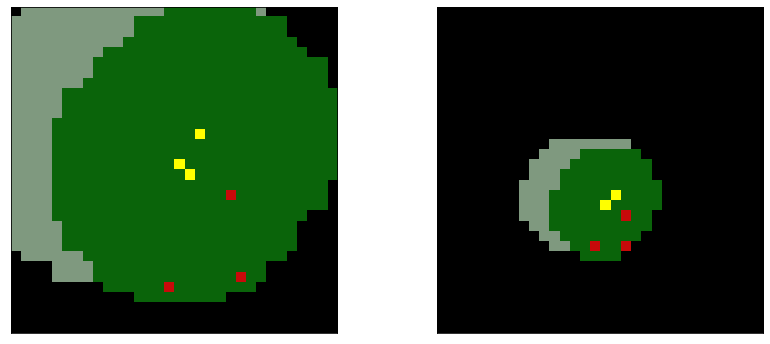

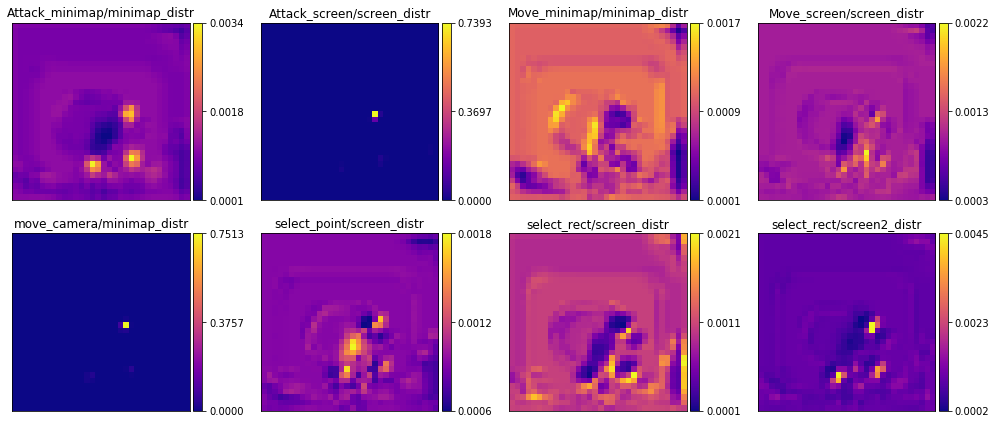


Step 18
Action select_army - prob: 0.170
Action Attack_screen - prob: 0.427
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.033
Action move_camera - prob: 0.058
Action Stop_quick - prob: 0.205
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.107
-----------------------------------
Action chosen:  select_army


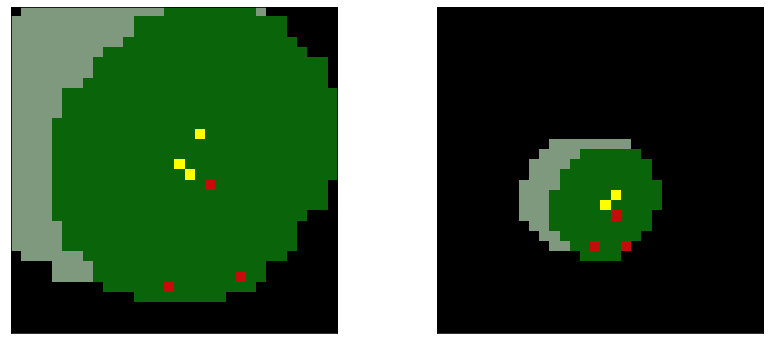

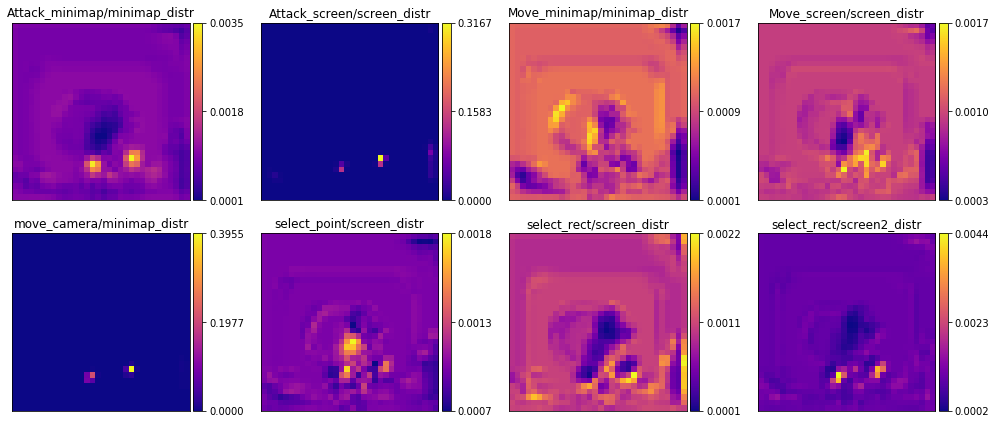


Step 19
Action select_army - prob: 0.160
Action Attack_screen - prob: 0.531
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.025
Action move_camera - prob: 0.012
Action Stop_quick - prob: 0.195
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.076
-----------------------------------
Action chosen:  select_army


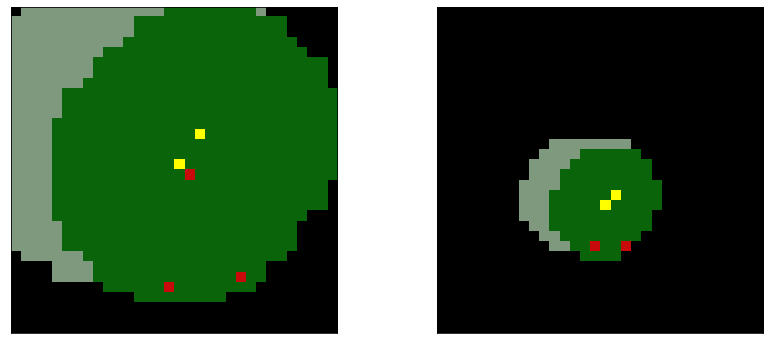

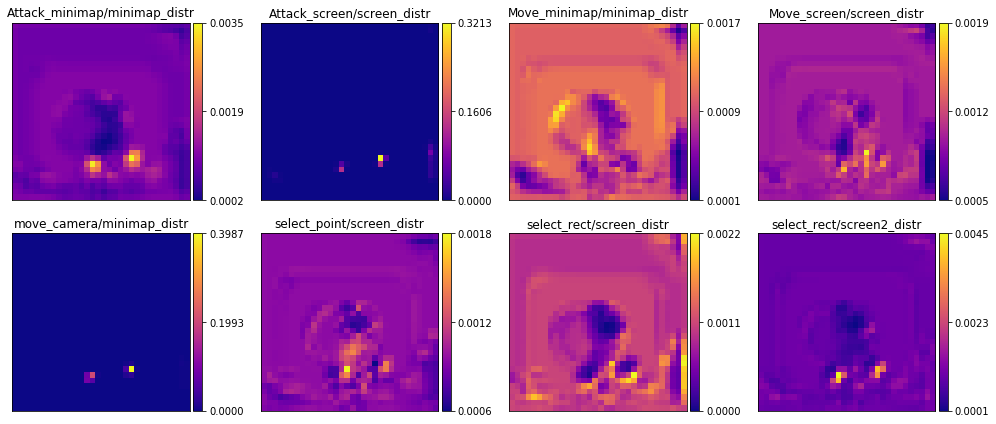


Step 20
Action select_army - prob: 0.125
Action Attack_screen - prob: 0.523
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.028
Action move_camera - prob: 0.060
Action Stop_quick - prob: 0.191
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.073
-----------------------------------
Action chosen:  Attack_screen


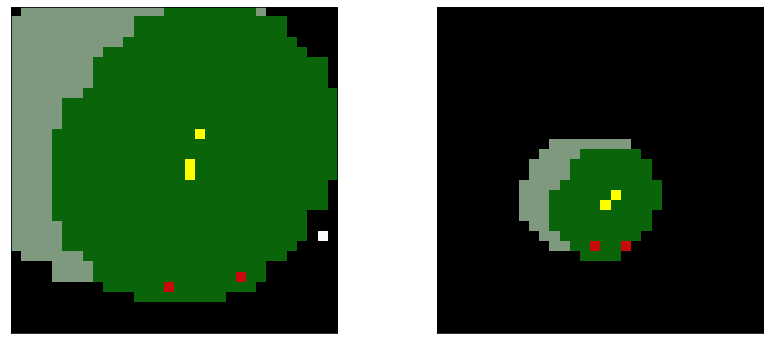

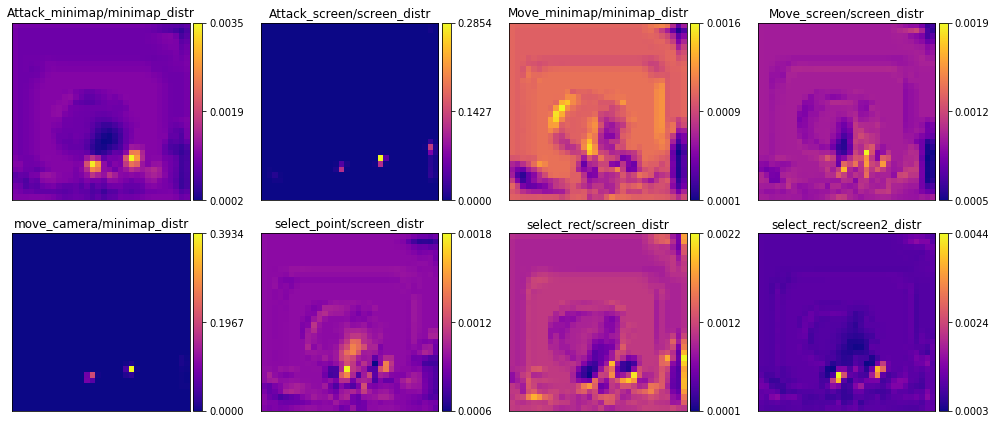


Step 21
Action select_army - prob: 0.112
Action Attack_screen - prob: 0.408
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.028
Action move_camera - prob: 0.176
Action Stop_quick - prob: 0.198
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.078
-----------------------------------
Action chosen:  Attack_screen


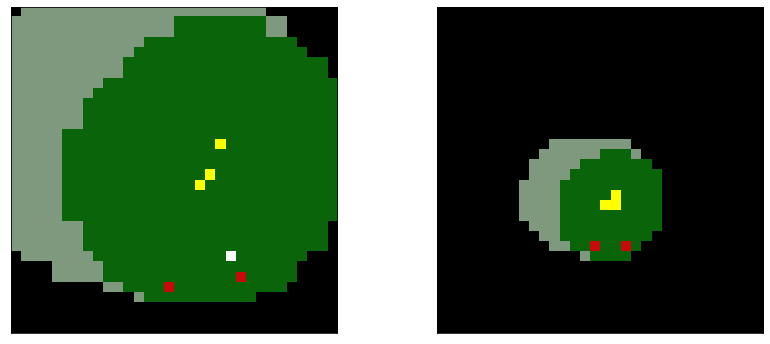

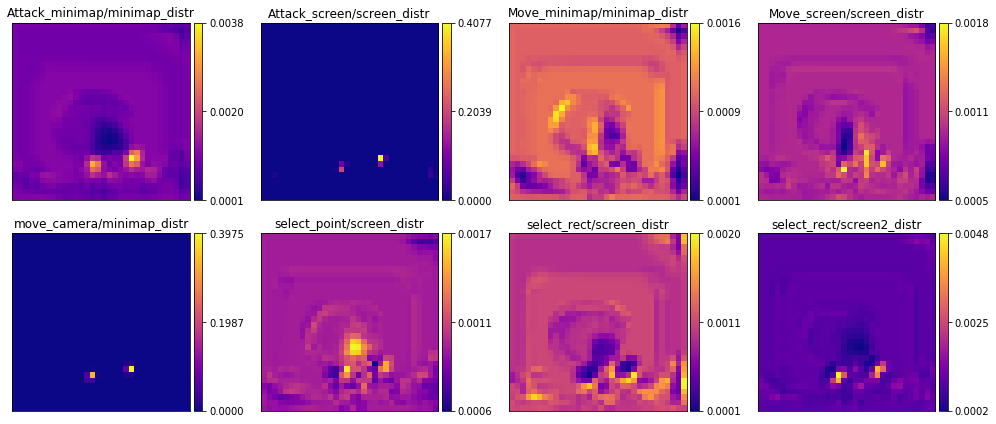


Step 22
Action select_army - prob: 0.096
Action Attack_screen - prob: 0.322
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.027
Action move_camera - prob: 0.304
Action Stop_quick - prob: 0.179
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.072
-----------------------------------
Action chosen:  Stop_quick


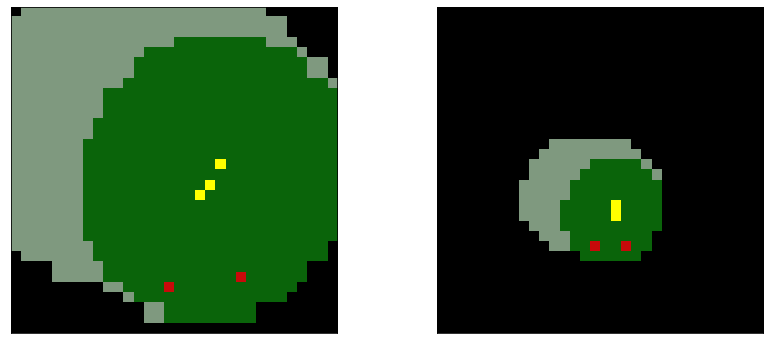

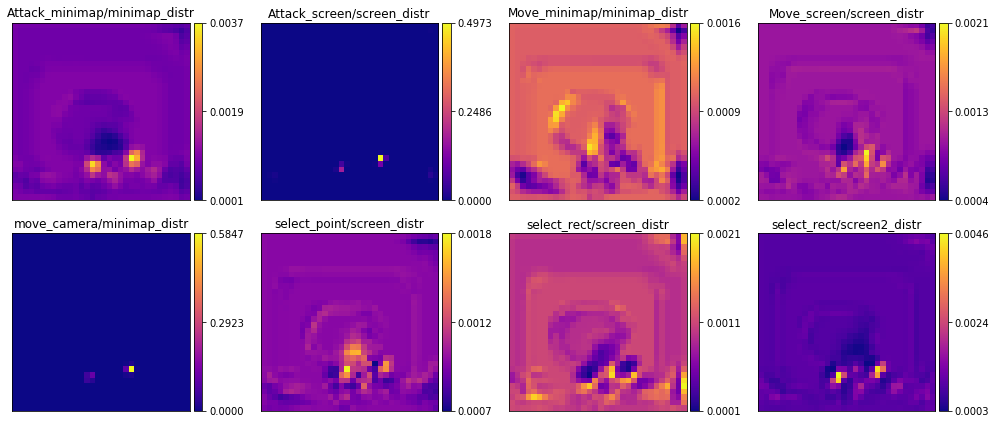


Step 23
Action select_army - prob: 0.066
Action Attack_screen - prob: 0.158
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.022
Action move_camera - prob: 0.555
Action Stop_quick - prob: 0.140
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.059
-----------------------------------
Action chosen:  Attack_screen


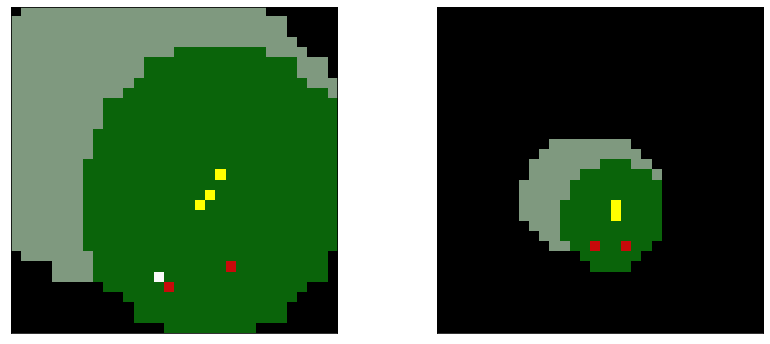

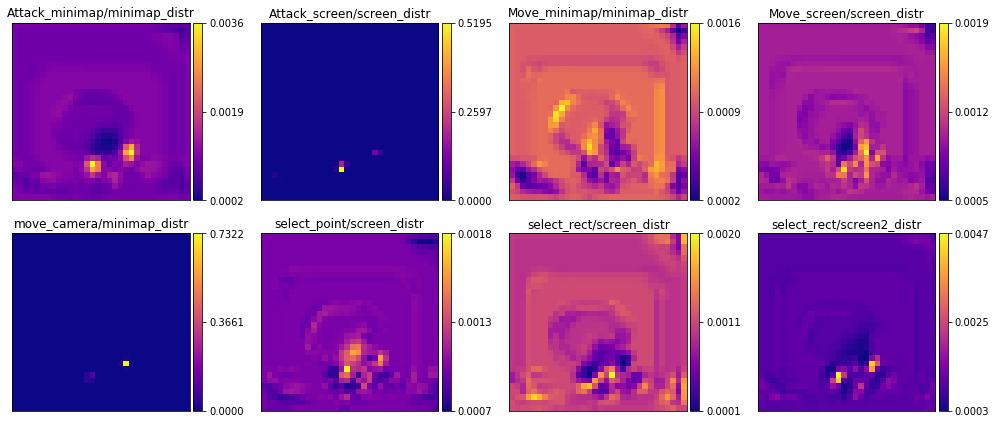


Step 24
Action select_army - prob: 0.089
Action Attack_screen - prob: 0.200
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.027
Action move_camera - prob: 0.443
Action Stop_quick - prob: 0.166
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.075
-----------------------------------
Action chosen:  move_camera


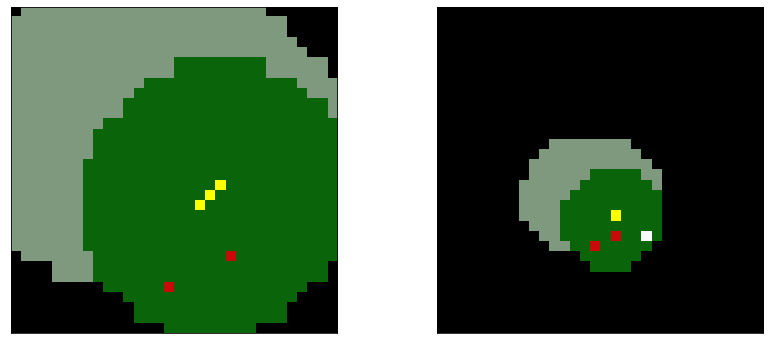

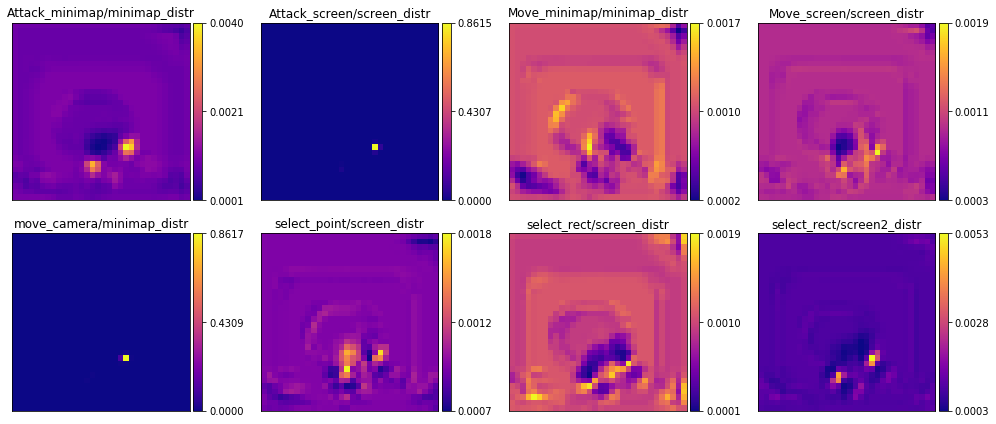


Step 25
Action select_army - prob: 0.205
Action Attack_screen - prob: 0.563
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.010
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.176
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.046
-----------------------------------
Action chosen:  select_army


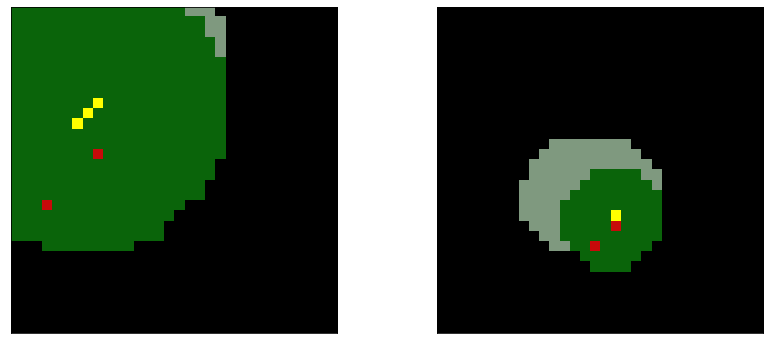

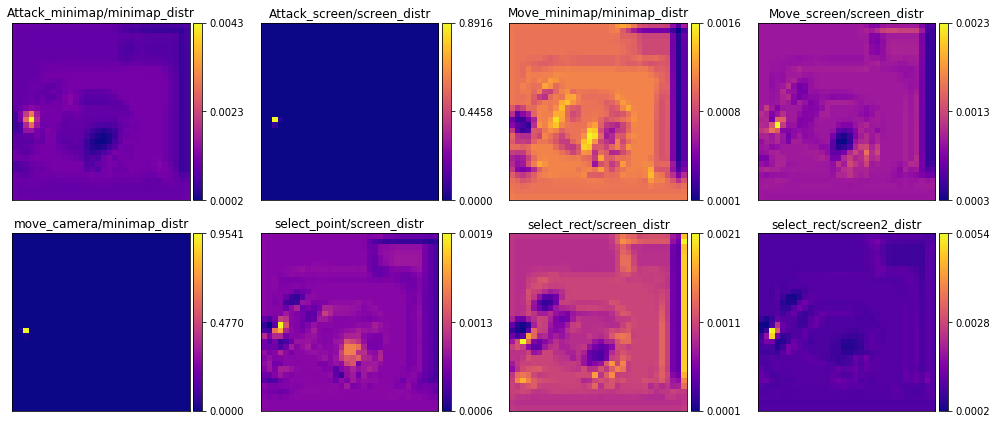


Step 26
Action select_army - prob: 0.073
Action Attack_screen - prob: 0.808
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.004
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.092
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.023
-----------------------------------
Action chosen:  Attack_screen


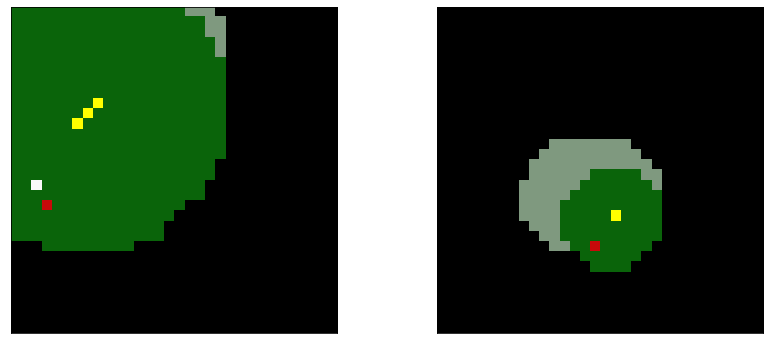

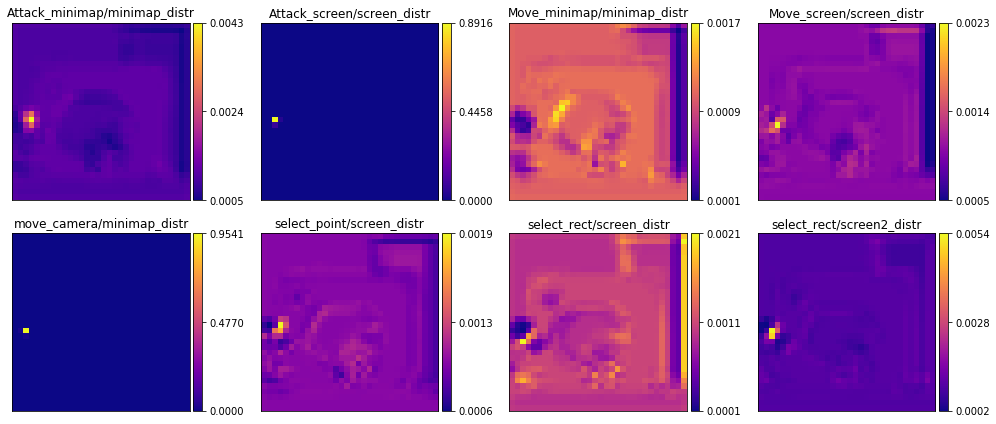


Step 27
Action select_army - prob: 0.172
Action Attack_screen - prob: 0.588
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.016
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.172
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.052
-----------------------------------
Action chosen:  Attack_screen


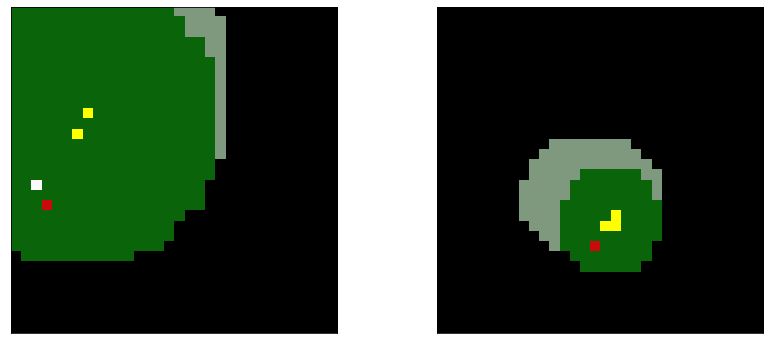

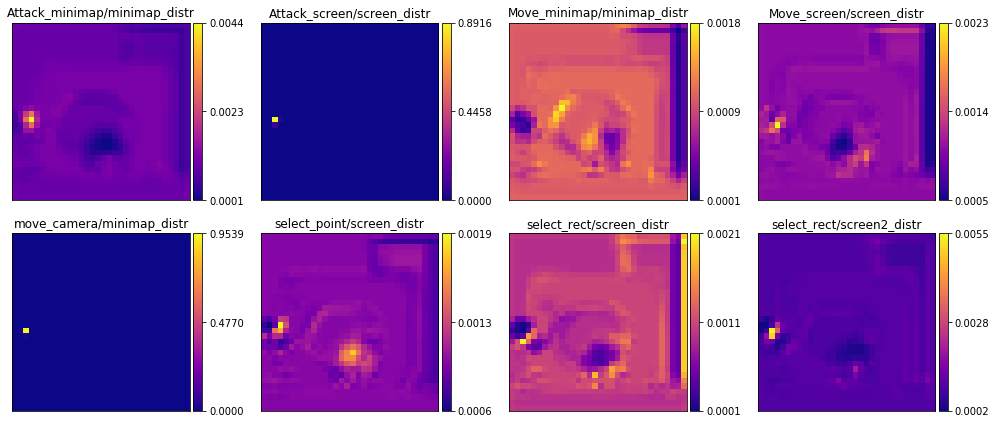


Step 28
Action select_army - prob: 0.161
Action Attack_screen - prob: 0.619
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.013
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.163
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.044
-----------------------------------
Action chosen:  select_army


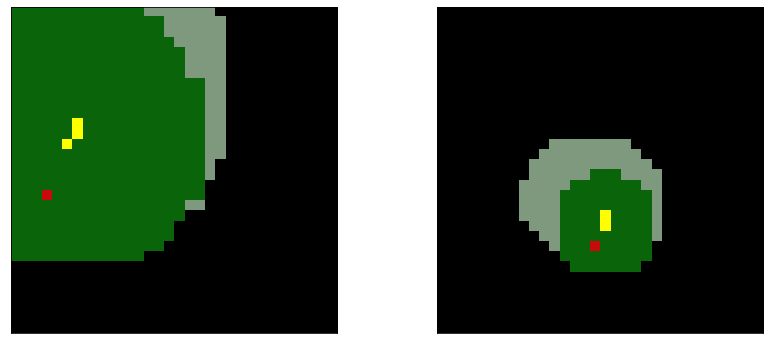

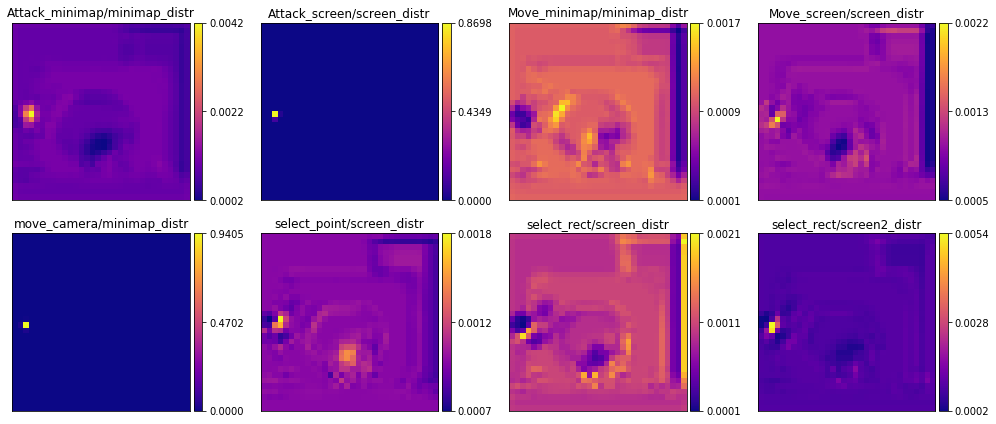


Step 29
Action select_army - prob: 0.154
Action Attack_screen - prob: 0.621
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.018
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.153
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.053
-----------------------------------
Action chosen:  Attack_screen


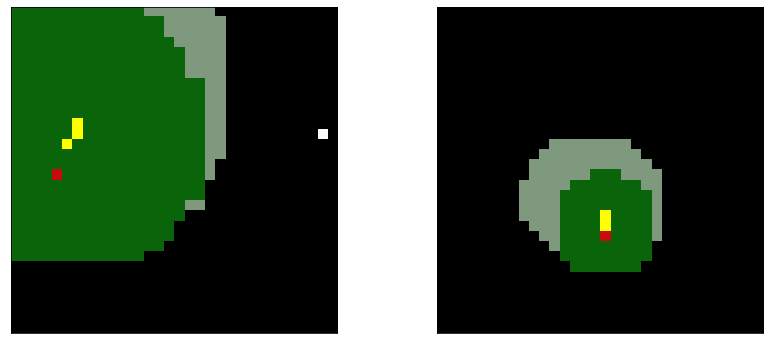

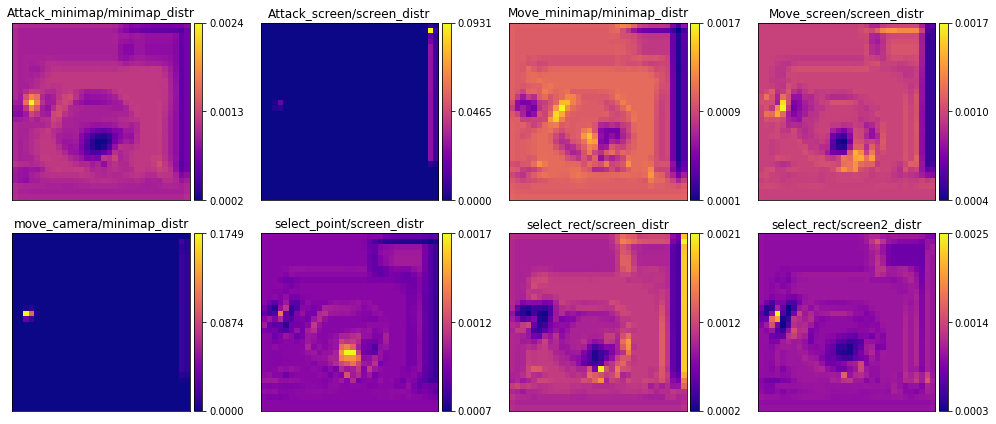


Step 30
Action select_army - prob: 0.052
Action Attack_screen - prob: 0.803
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.010
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.101
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.034
-----------------------------------
Action chosen:  Attack_screen


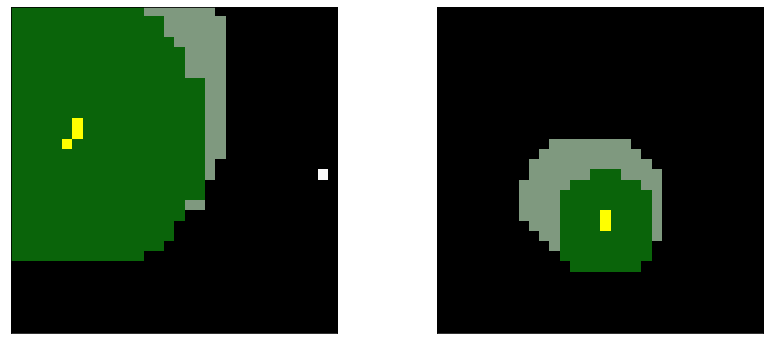

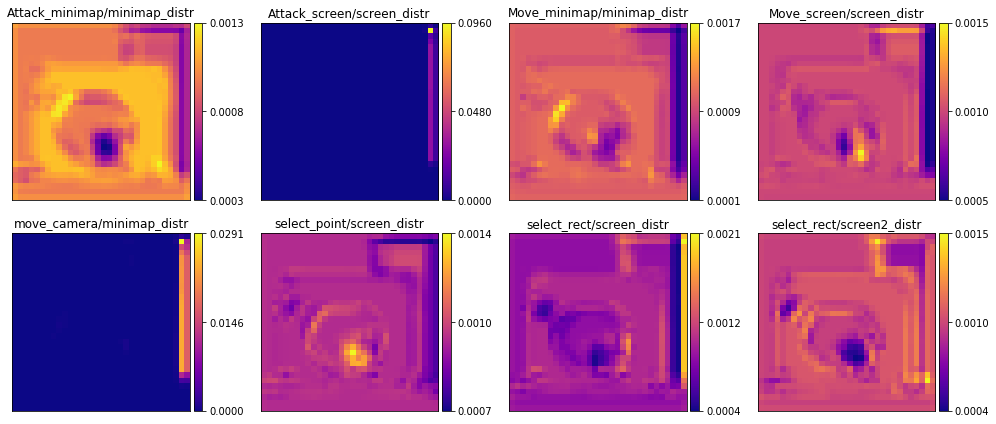


Step 31
Action select_army - prob: 0.070
Action Attack_screen - prob: 0.767
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.014
Action move_camera - prob: 0.001
Action Stop_quick - prob: 0.109
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.039
-----------------------------------
Action chosen:  Attack_screen


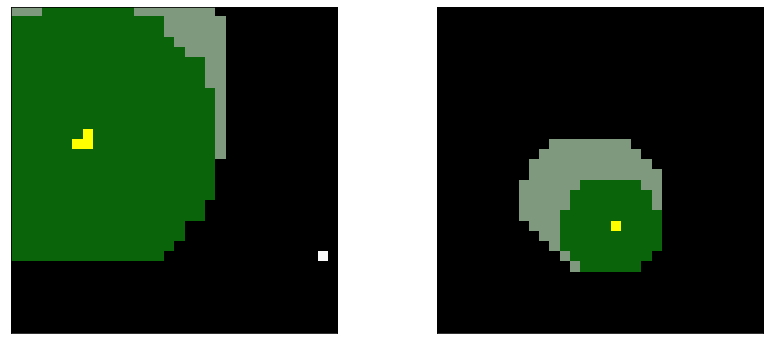

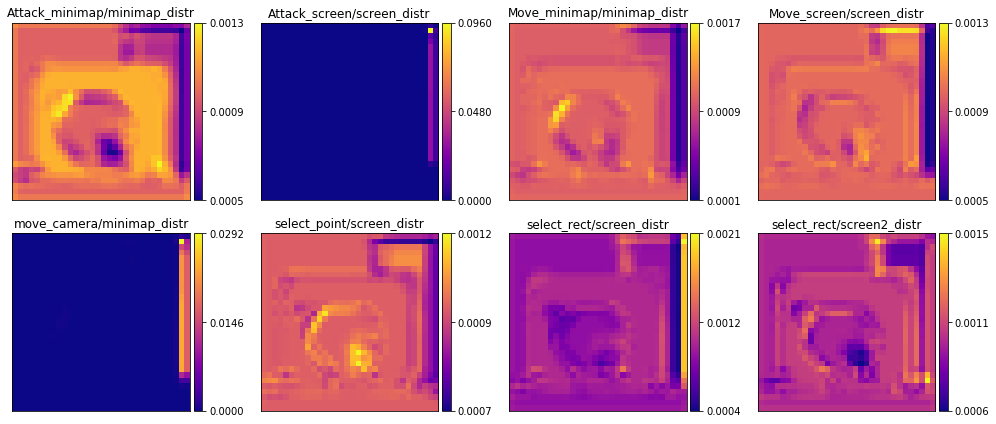


Step 32
Action select_army - prob: 0.148
Action Attack_screen - prob: 0.653
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.018
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.139
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.043
-----------------------------------
Action chosen:  Attack_screen


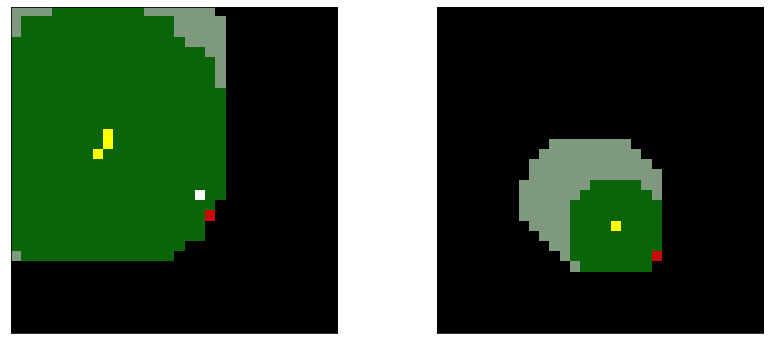

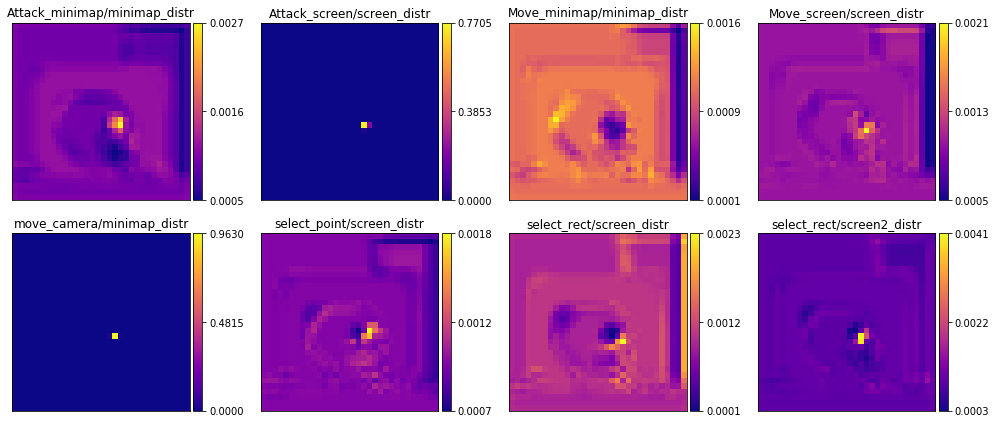


Step 33
Action select_army - prob: 0.147
Action Attack_screen - prob: 0.624
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.019
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.162
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.047
-----------------------------------
Action chosen:  select_army


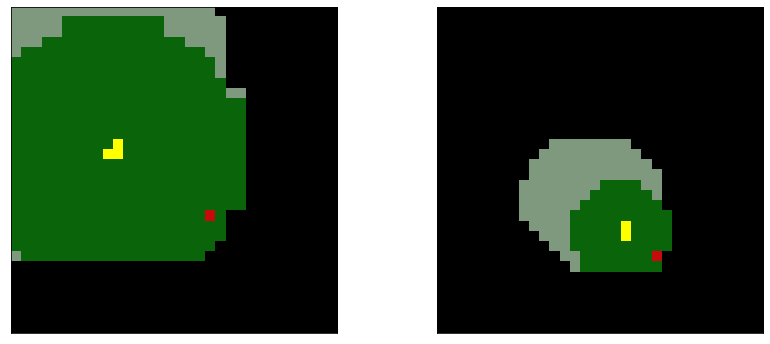

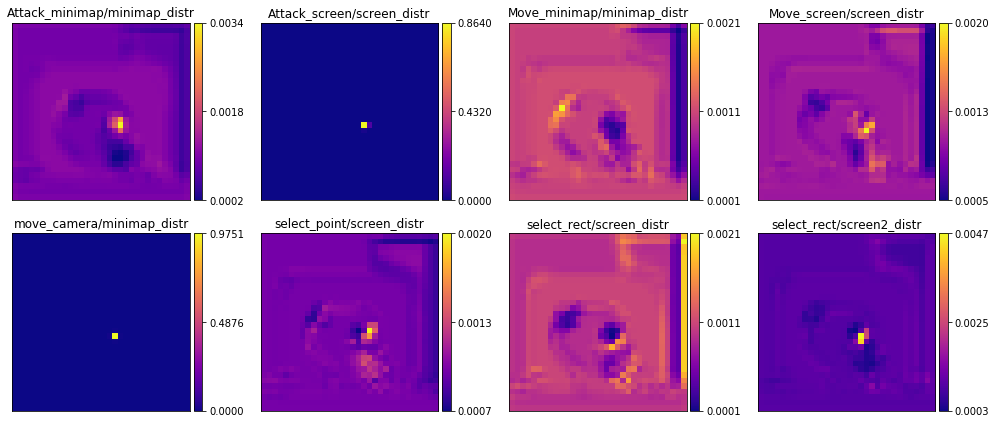


Step 34
Action select_army - prob: 0.146
Action Attack_screen - prob: 0.657
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.017
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.138
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.042
-----------------------------------
Action chosen:  Attack_screen


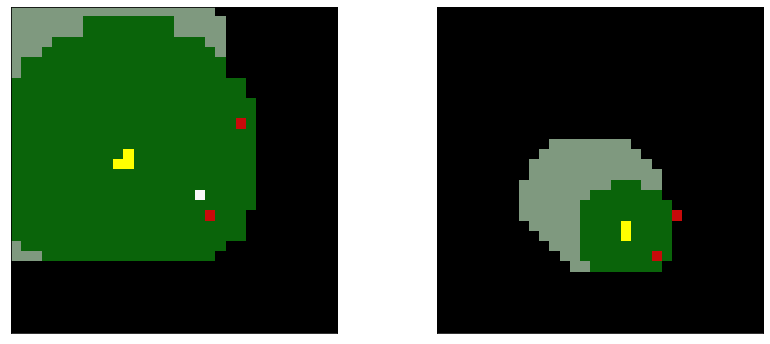

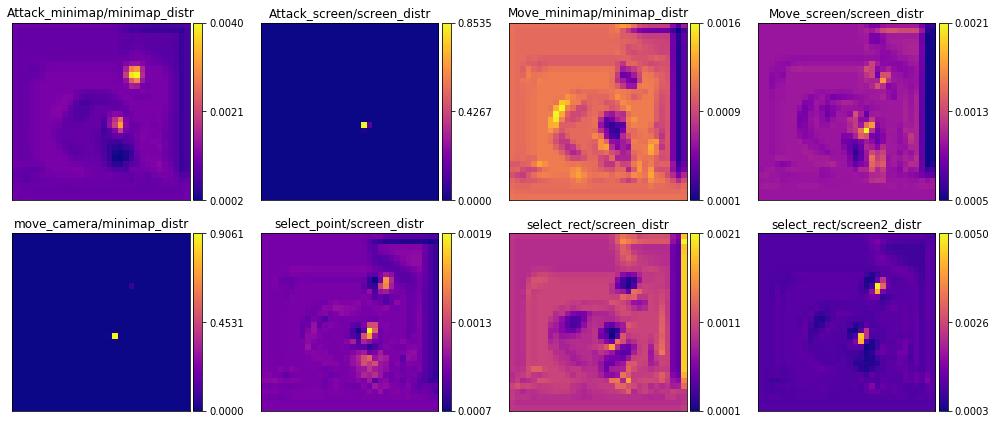


Step 35
Action select_army - prob: 0.143
Action Attack_screen - prob: 0.662
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.018
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.135
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.043
-----------------------------------
Action chosen:  Attack_screen


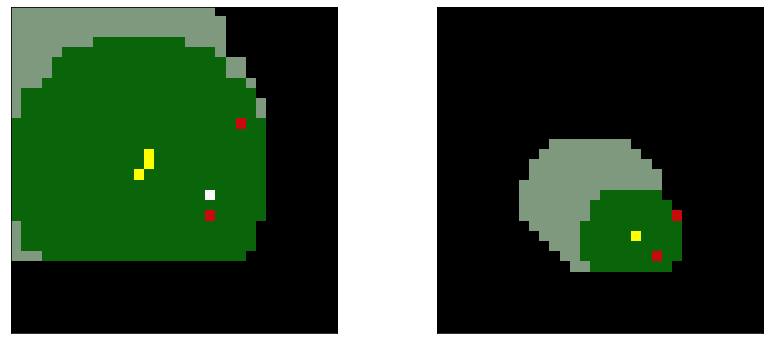

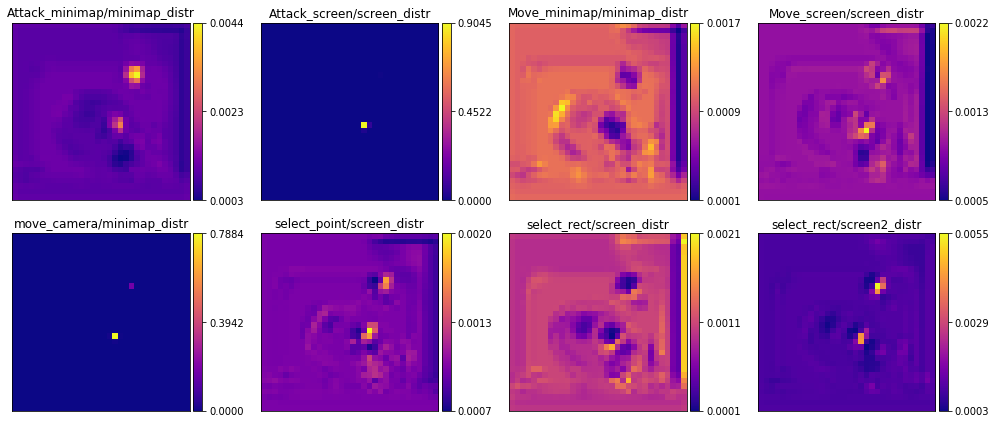


Step 36
Action select_army - prob: 0.135
Action Attack_screen - prob: 0.626
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.023
Action move_camera - prob: 0.001
Action Stop_quick - prob: 0.155
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.060
-----------------------------------
Action chosen:  Attack_screen


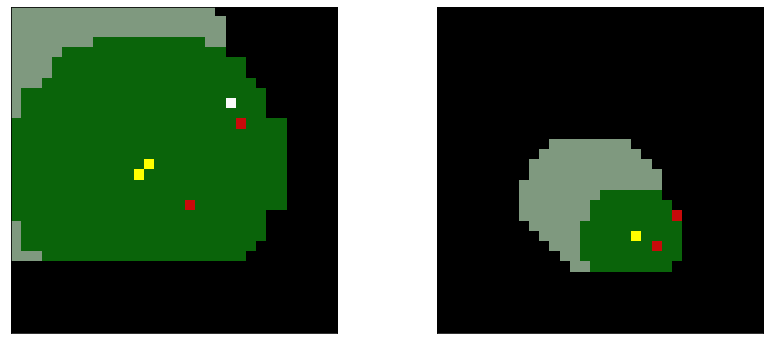

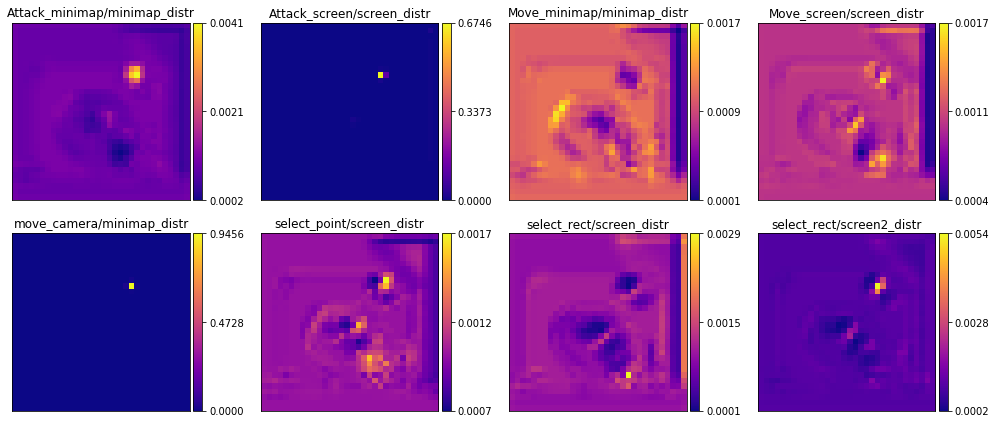


Step 37
Action select_army - prob: 0.128
Action Attack_screen - prob: 0.590
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.028
Action move_camera - prob: 0.006
Action Stop_quick - prob: 0.173
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.075
-----------------------------------
Action chosen:  HoldPosition_quick


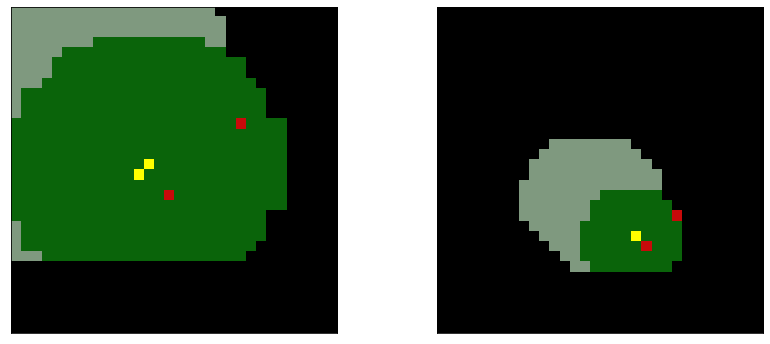

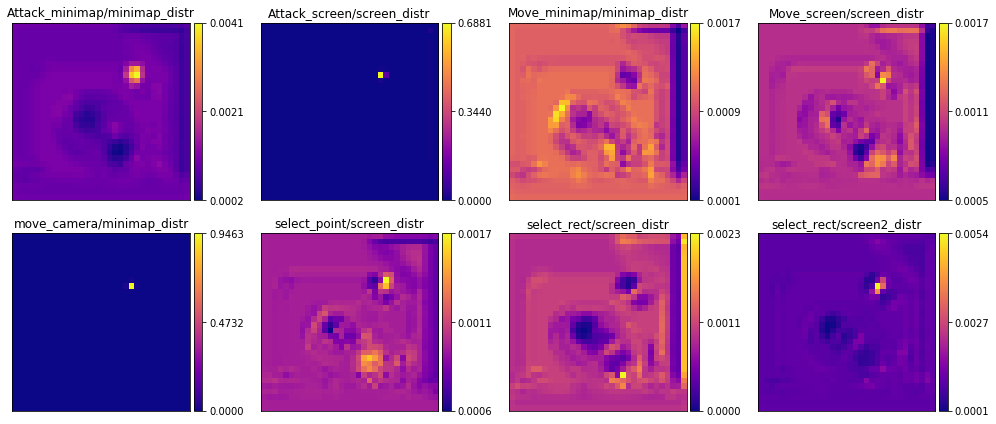


Step 38
Action select_army - prob: 0.132
Action Attack_screen - prob: 0.635
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.026
Action move_camera - prob: 0.001
Action Stop_quick - prob: 0.150
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.055
-----------------------------------
Action chosen:  Stop_quick


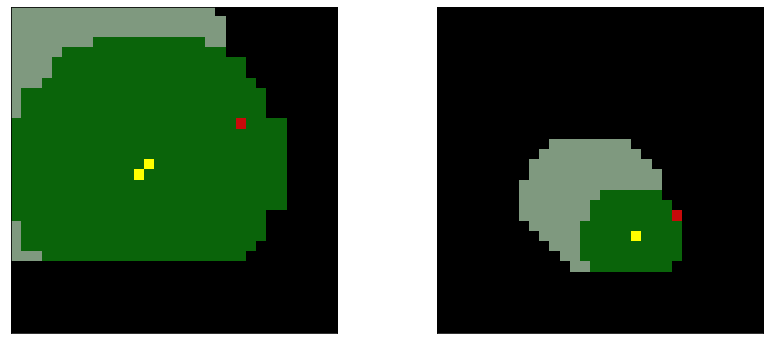

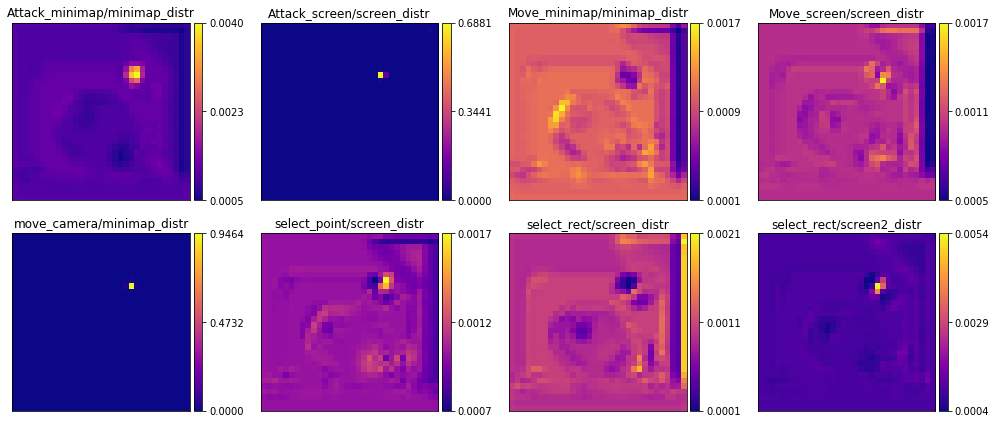


Step 39
Action select_army - prob: 0.131
Action Attack_screen - prob: 0.626
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.027
Action move_camera - prob: 0.002
Action Stop_quick - prob: 0.155
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.059
-----------------------------------
Action chosen:  Attack_screen


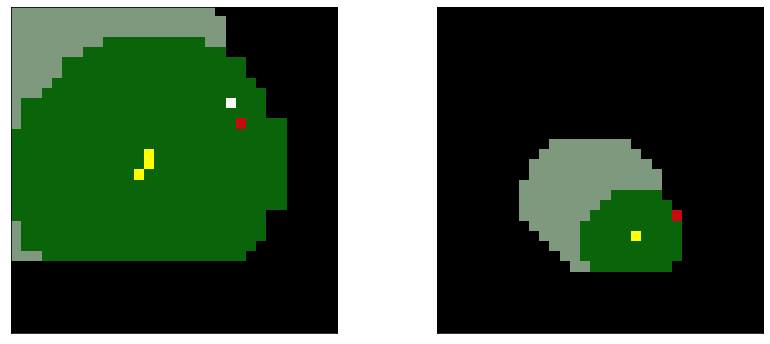

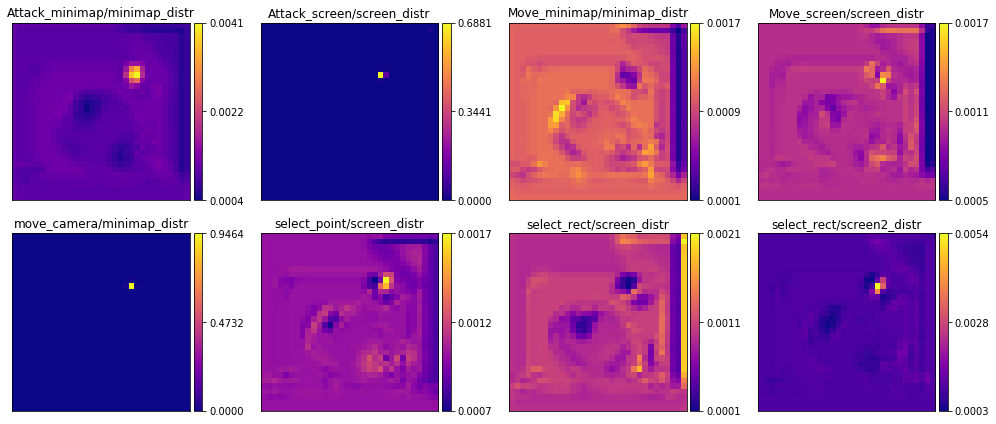


Step 40
Action select_army - prob: 0.132
Action Attack_screen - prob: 0.594
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.028
Action move_camera - prob: 0.003
Action Stop_quick - prob: 0.178
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.064
-----------------------------------
Action chosen:  select_army


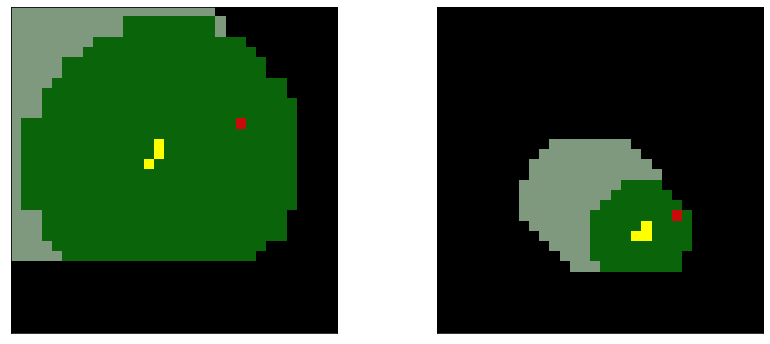

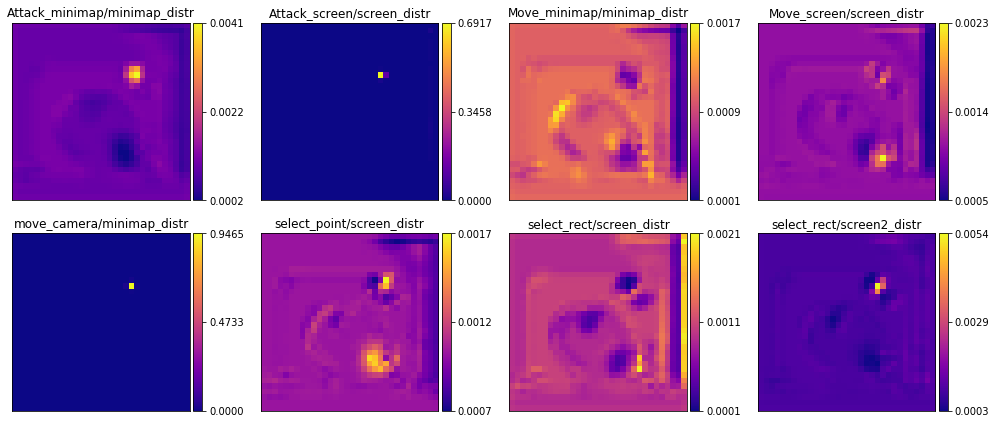


Step 41
Action select_army - prob: 0.138
Action Attack_screen - prob: 0.588
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.024
Action move_camera - prob: 0.001
Action Stop_quick - prob: 0.188
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.060
-----------------------------------
Action chosen:  Attack_screen


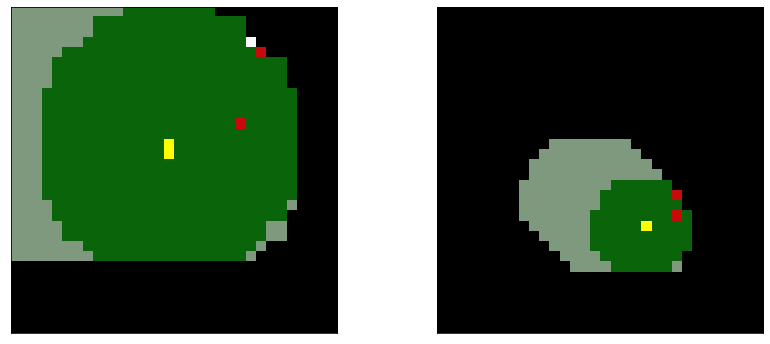

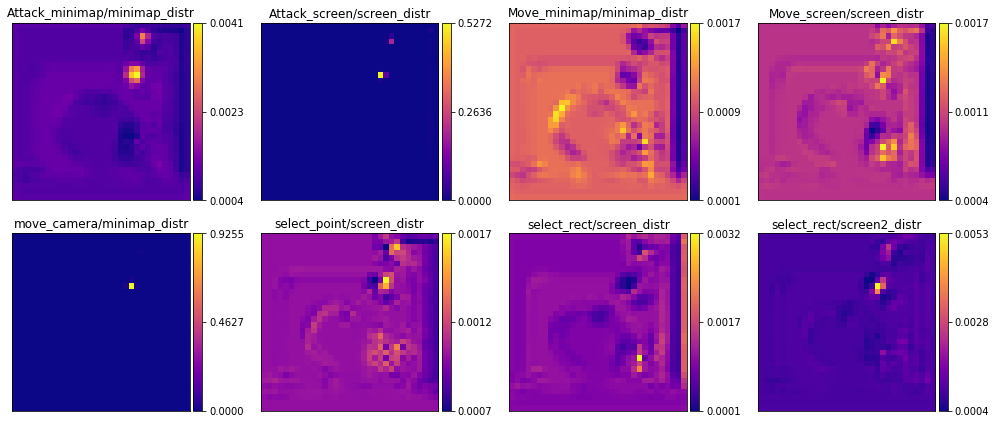


Step 42
Action select_army - prob: 0.148
Action Attack_screen - prob: 0.562
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.023
Action move_camera - prob: 0.001
Action Stop_quick - prob: 0.203
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.063
-----------------------------------
Action chosen:  Attack_screen


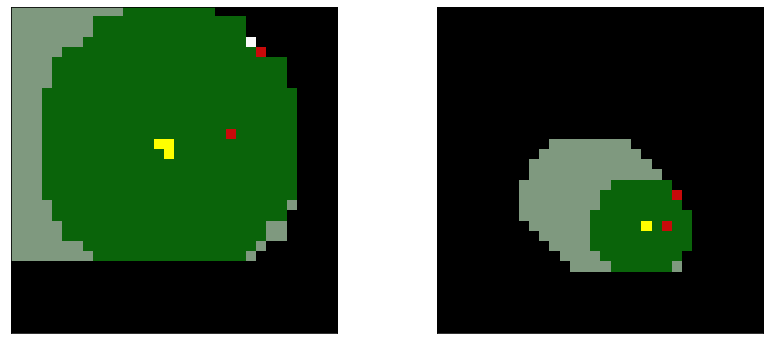

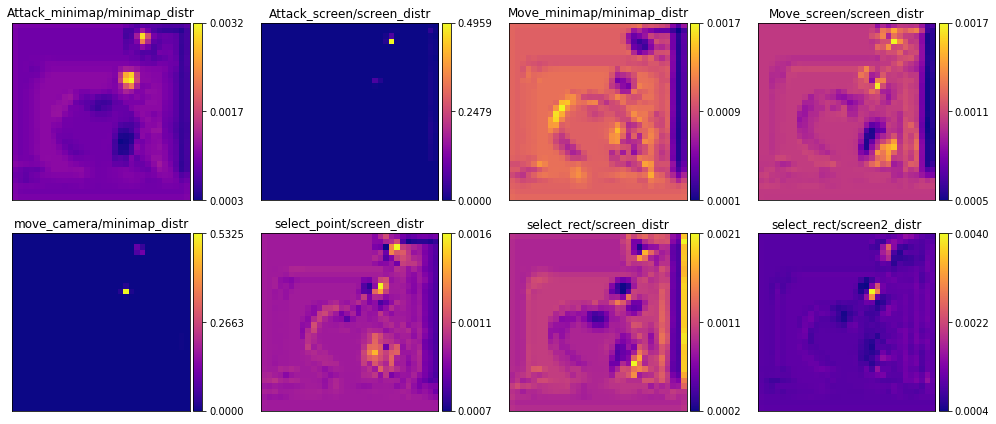


Step 43
Action select_army - prob: 0.146
Action Attack_screen - prob: 0.544
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.025
Action move_camera - prob: 0.002
Action Stop_quick - prob: 0.213
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.070
-----------------------------------
Action chosen:  Attack_screen


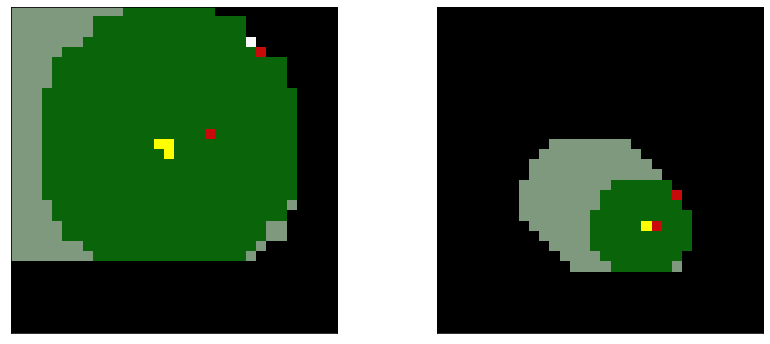

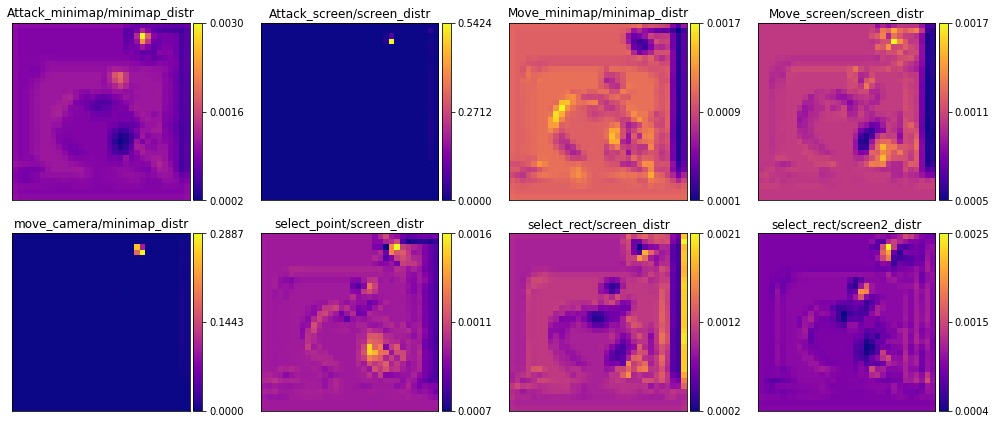


Step 44
Action select_army - prob: 0.110
Action Attack_screen - prob: 0.674
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.020
Action move_camera - prob: 0.001
Action Stop_quick - prob: 0.148
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.047
-----------------------------------
Action chosen:  Attack_screen


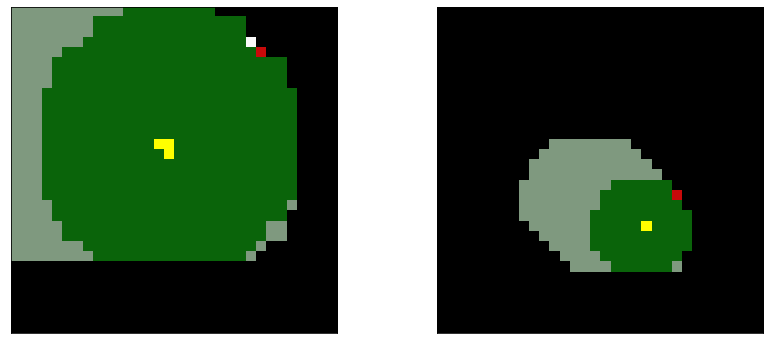

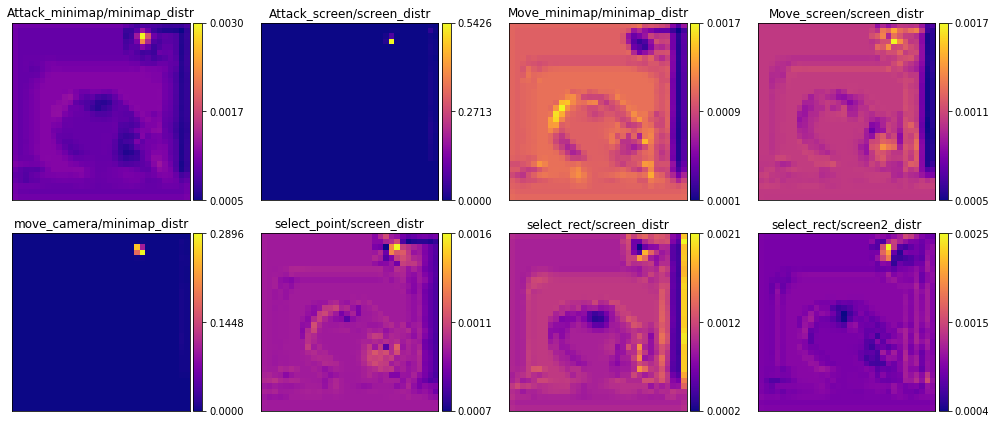


Step 45
Action select_army - prob: 0.131
Action Attack_screen - prob: 0.614
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.029
Action move_camera - prob: 0.002
Action Stop_quick - prob: 0.166
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.058
-----------------------------------
Action chosen:  Stop_quick


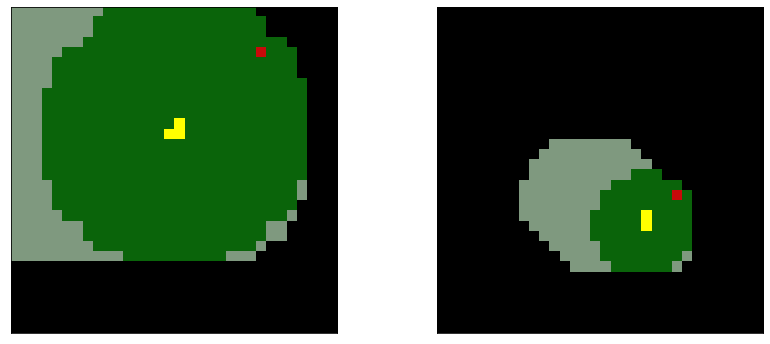

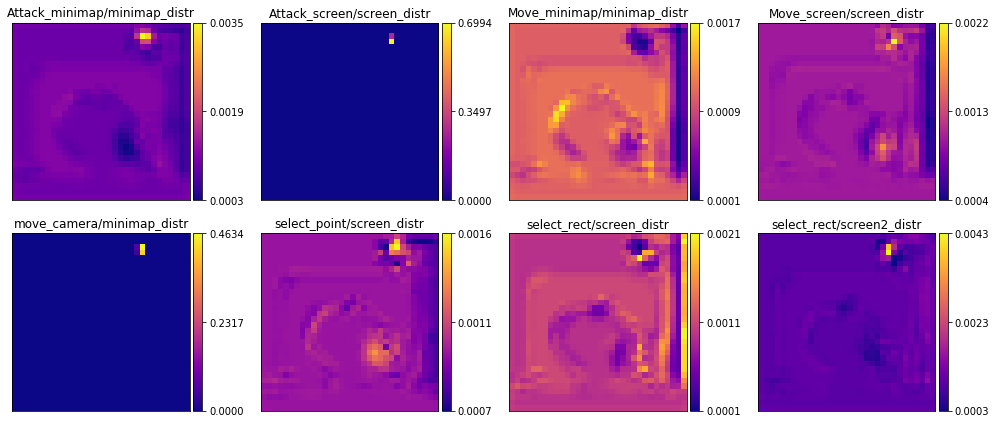


Step 46
Action select_army - prob: 0.103
Action Attack_screen - prob: 0.505
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.044
Action move_camera - prob: 0.105
Action Stop_quick - prob: 0.164
Action Move_minimap - prob: 0.001
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.078
-----------------------------------
Action chosen:  Attack_screen


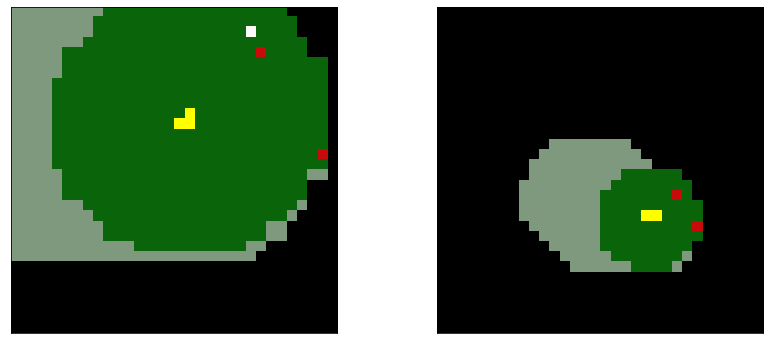

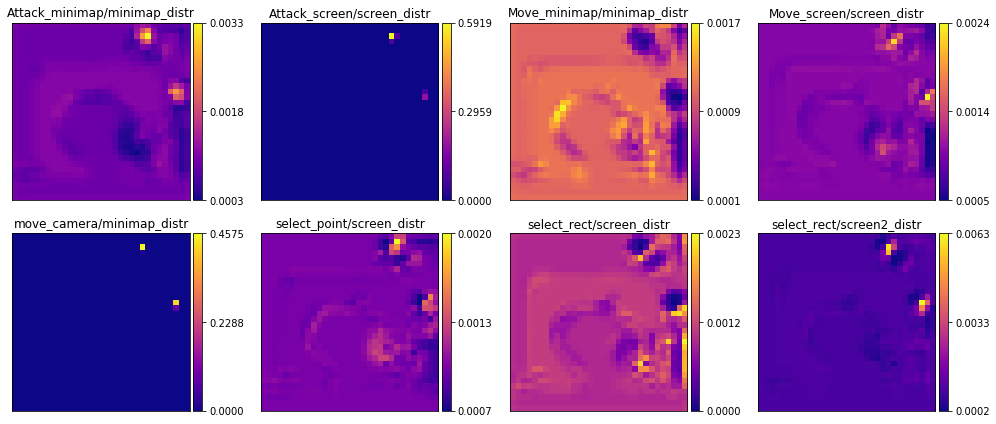


Step 47
Action select_army - prob: 0.104
Action Attack_screen - prob: 0.612
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.040
Action move_camera - prob: 0.036
Action Stop_quick - prob: 0.139
Action Move_minimap - prob: 0.001
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.068
-----------------------------------
Action chosen:  select_rect


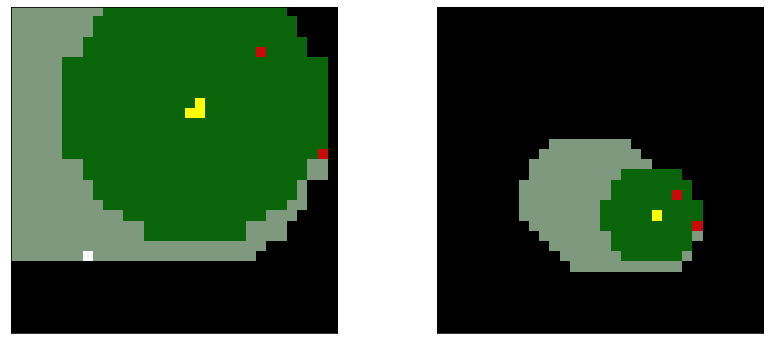

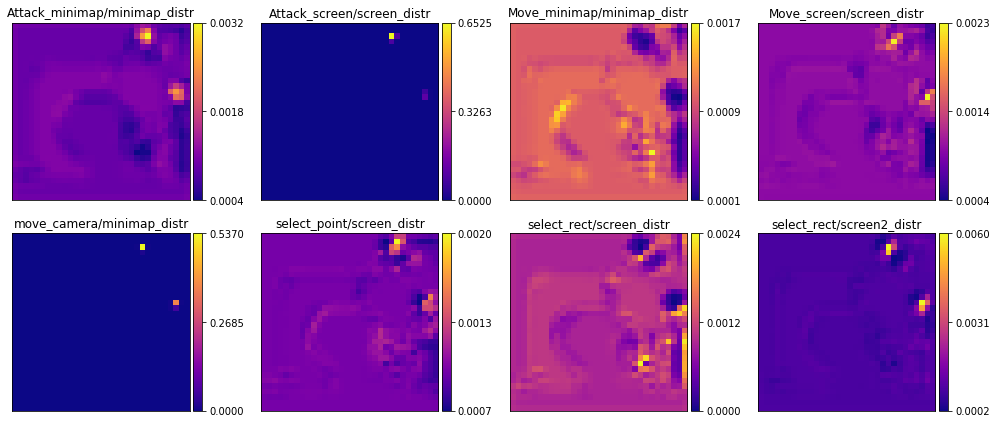


Step 48
Action select_army - prob: 0.065
Action Attack_screen - prob: 0.305
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.038
Action move_camera - prob: 0.418
Action Stop_quick - prob: 0.111
Action Move_minimap - prob: 0.001
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.063
-----------------------------------
Action chosen:  move_camera


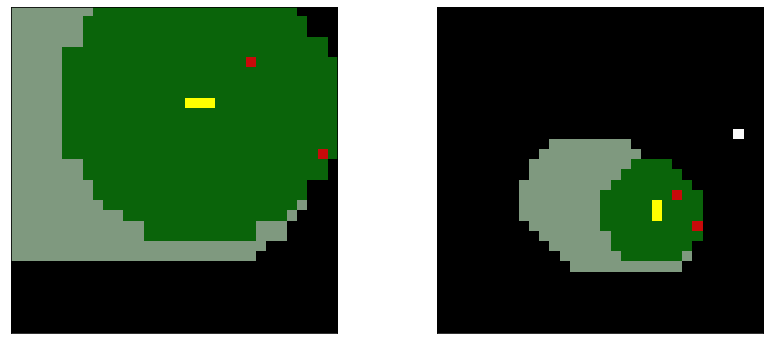

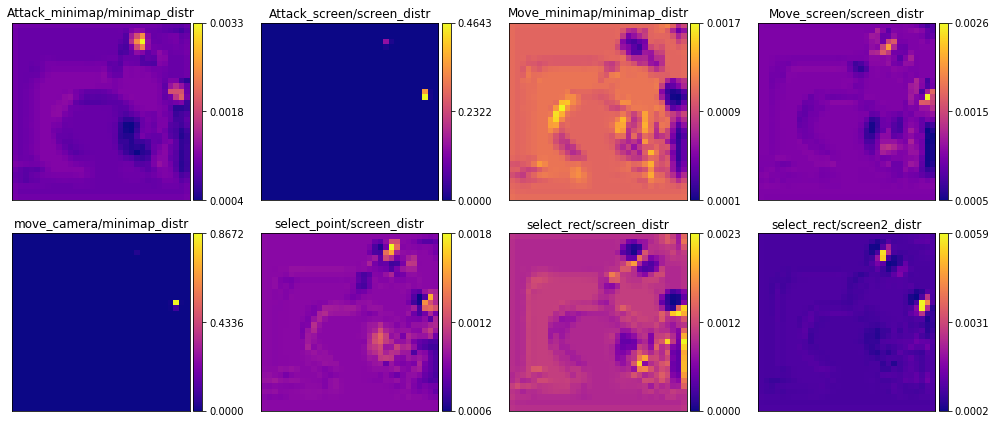


Step 49
Action select_army - prob: 0.177
Action Attack_screen - prob: 0.515
Action Move_screen - prob: 0.000
Action select_point - prob: 0.000
Action select_rect - prob: 0.020
Action move_camera - prob: 0.000
Action Stop_quick - prob: 0.218
Action Move_minimap - prob: 0.000
Action Attack_minimap - prob: 0.000
Action HoldPosition_quick - prob: 0.069
-----------------------------------
Action chosen:  Attack_screen


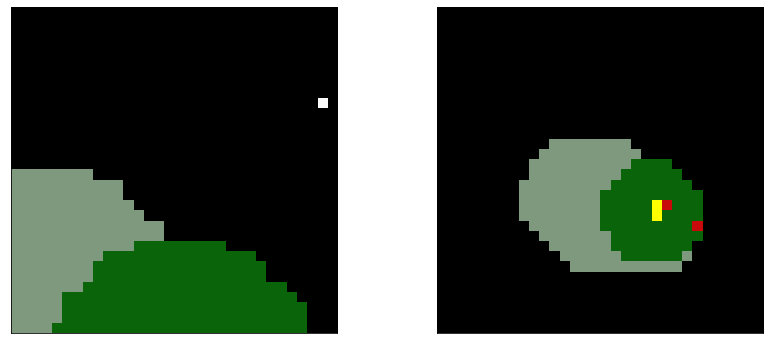

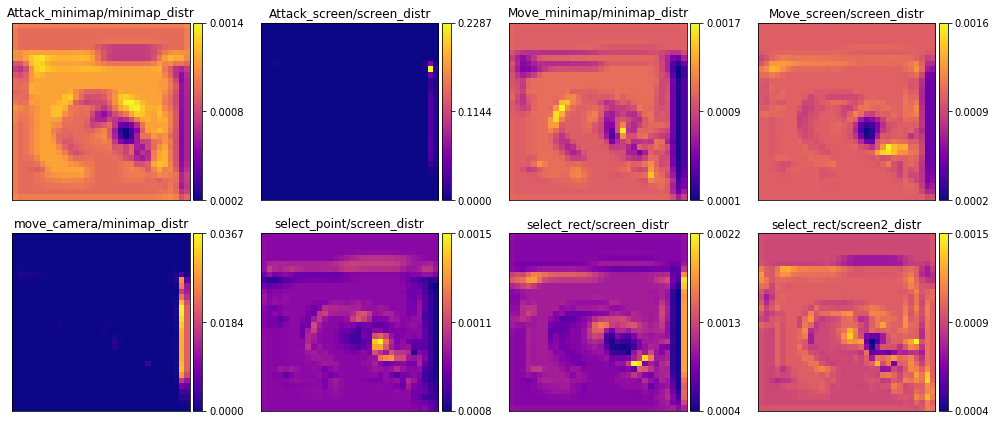

In [95]:
#for t in range(len(insp_dict['state_traj'])):
for t in range(50):
    print_action_info(inspector, insp_dict, t)
    plot_screen_and_decision(inspector, insp_dict, layer_names, t, show_minimap=True)
    #plot_screen_layers(insp_dict, layer_names, t)
    #plot_minimap_layers(insp_dict, layer_names, t)

# Entropy regularization test

1. $H=10^{-3}$, `PID='HHRC'`: 
    - Attack_screen 100% of the times
    
2. $H=10^{-2}$, `PID='ITJU'`: 
    - Action select_army - 9%
    - Action Attack_screen - 3%
    - Action Move_screen - 89%
    
3. $H=10^{-1}$, `PID='NQIB'`:
    - Action select_army - 33%
    - Action Attack_screen - 33%
    - Action Move_screen - 34%
    
4. Linear annealing from $H=10^{-2}$ to $H=10^{-3}$, `PID='SFFA'`:
    - Attack_screen 100% of the times
    
5. Linear annealing from $H=7*10^{-2}$ to $H=7*10^{-3}$, `PID='TYUY'`:
    - Action select_army - 10%
    - Action Attack_screen - 87%
    - Action Move_screen - 3%
    
6. Linear annealing from $H=5*10^{-2}$ to $H=5*10^{-3}$, `PID='HSKP'`:
    - Action select_army - 1%
    - Action Attack_screen - 2%
    - Action Move_screen - 96%
    
6. Linear annealing from $H=3*10^{-2}$ to $H=3*10^{-3}$, `PID='HSKP'`:
    - Action Attack_screen - 100%

So it seems that we have a problem, in the sense that within an order of magnitude we go from ininfluent regularization to a regularization that becomes the main objective.
We might have some options to do better:
1. Fine-tune H between $10^{-2}$ and $10^{-3}$
2. Use an annealing scheme for H, e.g. linear annealing

In [41]:
H_init = 1e-2
H_end = 1e-3
max_train_steps = 120000
unroll_length = 60
step_idx = unroll_length*2 # the important is to keep it a multiple of unroll_length / traj_length

class H_linear_schedule():
    def __init__(self, H_init, H_end, max_train_steps):
        self.H0 = H_init
        self.m = (H_end-H_init)/max_train_steps
        self.max_steps = max_train_steps
        
    def get_H(self, step_idx):
        # clip at max_step (independent assurance from init conditions)
        if step_idx > self.max_steps:
            step_idx = self.max_steps
        return self.H0 + self.m*step_idx

In [30]:
H_sched = H_linear_schedule(H_init, H_end, max_train_steps)
Hs = []
steps = [i for i in range(0, max_train_steps, 60)]
Hs = list(map(H_sched.get_H, steps))

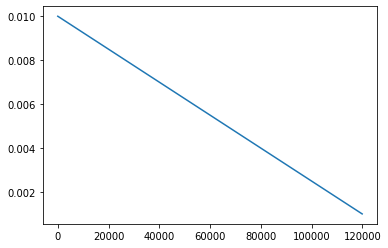

In [31]:
plt.plot(steps, Hs)